In [1]:
import sys
import os
sys.path.append('/usr0/home/drschwar/src/bert_brain/')
sys.path.append('/usr0/home/drschwar/src/subplot_artist')
sys.path.append('/usr0/home/drschwar/src/ocular')
sys.path.append('/usr0/home/drschwar/src/analytic_wavelet')
sys.path.append('/usr0/home/drschwar/src/analytic_wavelet_meg')
import json
import dataclasses
from collections import OrderedDict
from functools import partial

from tqdm.auto import trange, tqdm

import numpy as np
from scipy.stats import ttest_rel
from scipy.special import softmax
from scipy.spatial.distance import pdist, cdist, squareform

from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

import mne

from bert_brain_paths import Paths
from bert_brain import named_variations, task_hash, singleton_variation, \
    get_indices_from_normalized_coordinates, get_mask_for_subject, sentence_predictions, \
    read_variation_results, loss_curves_for_variation, average_unique_steps_within_loss_curves, \
    average_unique_epochs_within_loss_curves, average_over_runs, \
    two_sample_permutation_test, one_sample_permutation_test, Aggregator, sample_differences, \
    wilcoxon_axis, fdr_correction, read_predictions, k_vs_k, get_field_predictions, assemble_indexed_predictions, \
    get_model_weights, write_pairwise_metric_statistics, filter_pairwise_metric_statistics, StatisticsSpec, \
    compute_statistics_on_aggregated, batch_psim, batch_csim, indexed_mean
from analysis import print_variation_results, text_heat_map_html, remove_hp_fmri_prefix
from ocular import keyed_colors, bar_eval_key, make_label, bar_grouped, make_bar_group, DisplayName, \
    bar_group_best_for_eval, cmap_rgba_bytes, make_vertex_data, comparison_cmap_rgba_bytes
from element_analysis_harry_potter import dipole_aggregate
from occlusion import run_occlusion, read_occlusion_predictions, occlusion_sensitivity, sensitivity_delta_mse
%matplotlib inline
from subplot_artist import SubplotArtist, ColorbarArtist, render_subplot_artists, matshow, make_figure

import cortex

def make_volume(data, subject, mask=None, **kwargs):
    if mask is None:
        mask = get_mask_for_subject(subject)
    xfmname = '{}_ars_auto2'.format(subject)
    return cortex.Volume(data, 'fMRI_story_{}'.format(subject), xfmname, mask=mask, **kwargs)

key_to_color = keyed_colors(('elan', 'lan', 'n400', 'epnp', 'p600', 'pnp'))

display_name = DisplayName({
    ('epnp', 'pnp', 'elan', 'lan', 'n400', 'p600'): 'all erp'})

make_label_fn = partial(make_label, display_name)

structurals = {
    ('harryPotter', 'A'): 'struct4',
    ('harryPotter', 'B'): 'struct5',
    ('harryPotter', 'C'): 'struct6',
    ('harryPotter', 'D'): 'krns5D',
    ('harryPotter', 'E'): 'struct2',
    ('harryPotter', 'F'): 'krns5A',
    ('harryPotter', 'G'): 'struct1',
    ('harryPotter', 'H'): 'struct3',
    ('harryPotter', 'I'): 'krns5C'
}

inv_path = '/share/volume0/newmeg/{experiment}/data/inv/' + \
        '{subject}/{subject}_{experiment}_trans-D_nsb-5_cb-0_raw-{structural}-7-0.2-0.8-limitTrue-rankNone-inv.fif'
struct_dir = '/share/volume0/drschwar/structural'
    
def load_inverse_op(experiment, subject):
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        filled_inv_path = inv_path.format(
            subject=subject,
            experiment=experiment,
            structural=structurals[(experiment, subject)])
        return mne.minimum_norm.read_inverse_operator(filled_inv_path, verbose=False)
        
def load_annotation_labels(experiment, subject, structural_label_regex=None):
    import warnings
    with warnings.catch_warnings():
        return mne.read_labels_from_annot(
            subject=structurals[(experiment, subject)],
            parc='aparc', subjects_dir=struct_dir, regexp=structural_label_regex)

paths = Paths()

In [2]:
# variation_name = 'fmri_raw_dds_direct'
# graph_parts_to_compare = {
#     'max_pool_linear_1_span', 
#     'max_pool_linear_2_spans', 
#     'fmri_linear', 
#     'default_sequence_linear', 
#     'default_pooled_linear'}

# ordered_names, index_runs, weights = get_model_weights(paths, variation_name, graph_parts_to_compare)
# np.savez('model_weights.npz', ordered_names=ordered_names, index_runs=index_runs, weights=weights)

In [6]:
similarities_mean = dict()
similarities_std = dict()
for i in trange(6):
    variation_name = 'fmri_raw_dds_direct{}'.format('' if i == 0 else '_mixed_{}'.format(i))
    _, settings = singleton_variation(variation_name)
    covariance_estimates_cov = dict()
    covariance_estimates_means = dict()
    for index_run in range(settings.num_runs):
        covariance_path = os.path.join(
            paths.result_path, variation_name, task_hash(settings), 'run_{}'.format(index_run), 'covariance_estimates.npz')
        with np.load(covariance_path) as cov:
            splits = cov['splits']
            names = cov['names']
            if index_run == 0:
                for name in names:
                    covariance_estimates_means[name] = dict()
                    covariance_estimates_cov[name] = dict()
                    for split in splits:
                        covariance_estimates_means[name][split] = list()
                        covariance_estimates_cov[name][split] = list()
            else:
                for name in names:
                    assert(name in covariance_estimates_means)
                    for split in splits:
                        assert(split in covariance_estimates_means[name])
                for name in covariance_estimates_means:
                    assert(name in names)
                    for split in covariance_estimates_means[name]:
                        assert(split in splits)
            for name in names:
                for split in splits:
                    covariance_estimates_means[name][split].append(cov['mean_{}_{}'.format(name, split)])
                    covariance_estimates_cov[name][split].append(cov['covariance_{}_{}'.format(name, split)])
    for name in covariance_estimates_means:
        for split in covariance_estimates_means[name]:
            covariance_estimates_means[name][split] = np.array(covariance_estimates_means[name][split])
            covariance_estimates_cov[name][split] = np.array(covariance_estimates_cov[name][split])
            
    full_cov = covariance_estimates_cov['sequence_all_bottleneck']['__all__']
    
    graph_parts_to_compare = {
        'max_pool_linear_1_span', 
        'max_pool_linear_2_spans', 
        'fmri_linear', 
        'default_sequence_linear', 
        'default_pooled_linear'}
    ordered_names, index_runs, weights = get_model_weights(paths, variation_name, graph_parts_to_compare)
    obj_num_weights = None
    subj_num_weights = None
    tense_weights = None
    np_pp_weights = None
    for i, n in enumerate(ordered_names):
        if n == 'obj_num':
            obj_num_weights = weights[:, i:i+1]
        elif n == 'tense':
            tense_weights = weights[:, i:i+1]
        elif n == 'subj_num':
            subj_num_weights = weights[:, i:i+1]
        elif n == 'top_const.NP_PP_.':
            np_pp_weights = weights[:, i:i+1]
    assert(obj_num_weights is not None)
    assert(tense_weights is not None)
    assert(subj_num_weights is not None)
    assert(np_pp_weights is not None)
    weights = np.concatenate([obj_num_weights, tense_weights, subj_num_weights, np_pp_weights], axis=1)
    weights = np.asarray(weights, dtype=np.float64)
         
    for transform in ['cos', 'abs']:
         
        sim = batch_psim(weights, metric='covariance_scaled_cosine', cov=full_cov)
        if transform == 'abs':
            sim = np.abs(sim)
        sampled_means = list()
        for _ in range(len(sim)):
            indices_sample = np.random.choice(len(sim), len(sim))
            sampled_means.append(np.mean(sim[indices_sample], axis=0))
        if transform not in similarities_mean:
            similarities_mean[transform] = list()
            similarities_std[transform] = list()
        sampled_means = np.array(sampled_means)
        similarities_mean[transform].append(np.mean(sampled_means, axis=0))
        similarities_std[transform].append(np.std(sampled_means, axis=0))
        
for key in similarities_mean:
    similarities_mean[key] = np.asarray(similarities_mean[key])
    similarities_std[key] = np.asarray(similarities_std[key])
           

In [11]:
sa = list()
for _ in range(7):
    sa.append(SubplotArtist(width=5, height=5))
fig, axes = make_figure(sa, num_columns=3, dpi=180)
names = 'obj_num', 'tense', 'subj_num', 'tc.NP_PP_.'
i_ax = 0
for idx_a in range(3):
    for idx_b in range(idx_a + 1, 4):
        ax = axes[i_ax]
        i_ax += 1
        for key in similarities_mean:
            x = np.arange(len(similarities_mean[key])) * 0.1
            ax.errorbar(
                x=x, y=similarities_mean[key][:, idx_a, idx_b], 
                yerr=similarities_std[key][:, idx_a, idx_b], 
                label=key)
            ax.set_xlabel('Mixing proportion')
            ax.set_ylabel('Similarity')
            ax.set_title('{}/{} sim. vs. mixing prop.'.format(names[idx_a], names[idx_b]))
        ax.legend()
ax = axes[-1]
for n in acc:
    x = np.arange(len(similarities_mean[key])) * 0.1
    ax.plot(x, acc[n], label=n)
    ax.set_xlabel('Mixing proportion')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy vs. mixing prop.')
    ax.legend()
# fig.show()
fig.show(output_figure_path='mixing_prop_all.png')

In [8]:
acc = OrderedDict()
p_val = OrderedDict()
for i in trange(6):
    variation_name = 'fmri_raw_dds_direct{}'.format('' if i == 0 else '_mixed_{}'.format(i))
    statistics_spec = StatisticsSpec(regression_metric='r', classifier_metric='acc')

    full_variation_results = compute_statistics_on_aggregated(
        paths, variation_name, statistics_spec)
    for n in ['obj_num', 'tense', 'subj_num', 'top_const']:
        if n not in acc:
            acc[n] = list()
            p_val[n] = list()
        acc[n].append(full_variation_results[n].model_mean)
        p_val[n].append(full_variation_results[n].p_values)
        
for n in acc:
    print(acc[n])
    print(p_val[n])

/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)




[0.5890234375, 0.5190234375, 0.51642578125, 0.52166015625, 0.5184375, 0.51240234375]
[3.7815199872492322e-19, 0.8449137578125271, 0.8890851499740848, 0.06616241055232953, 0.33407498952452186, 0.3417266891555967]
[0.75572265625, 0.56943359375, 0.5513671875, 0.56080078125, 0.5463671875, 0.5505078125]
[5.350112436699663e-39, 2.664669274135589e-09, 0.00012966962137159196, 3.511667255207526e-06, 0.0003738738443081755, 5.943971712676691e-06]
[0.641796875, 0.62904296875, 0.62671875, 0.62806640625, 0.635, 0.63140625]
[6.078630701945346e-23, 4.538965114696718e-19, 1.2766088899906839e-19, 1.7126353367252067e-21, 5.926804299181305e-22, 1.9193491312172458e-18]
[0.30505859375, 0.28634765625, 0.2849609375, 0.30302734375, 0.288671875, 0.3180078125]
[6.795626957596215e-29, 2.2112033871746735e-25, 2.6895765228275935e-23, 6.465769572759137e-27, 1.715217374972895e-26, 8.295299439468146e-27]


In [2]:
variation_name = 'fmri_raw_dds_direct'
_, settings = singleton_variation(variation_name)
covariance_estimates_cov = dict()
covariance_estimates_means = dict()
for index_run in range(settings.num_runs):
    covariance_path = os.path.join(
        paths.result_path, variation_name, task_hash(settings), 'run_{}'.format(index_run), 'covariance_estimates.npz')
    with np.load(covariance_path) as cov:
        splits = cov['splits']
        names = cov['names']
        if index_run == 0:
            for name in names:
                covariance_estimates_means[name] = dict()
                covariance_estimates_cov[name] = dict()
                for split in splits:
                    covariance_estimates_means[name][split] = list()
                    covariance_estimates_cov[name][split] = list()
        else:
            for name in names:
                assert(name in covariance_estimates_means)
                for split in splits:
                    assert(split in covariance_estimates_means[name])
            for name in covariance_estimates_means:
                assert(name in names)
                for split in covariance_estimates_means[name]:
                    assert(split in splits)
        for name in names:
            for split in splits:
                covariance_estimates_means[name][split].append(cov['mean_{}_{}'.format(name, split)])
                covariance_estimates_cov[name][split].append(cov['covariance_{}_{}'.format(name, split)])
for name in covariance_estimates_means:
    for split in covariance_estimates_means[name]:
        covariance_estimates_means[name][split] = np.array(covariance_estimates_means[name][split])
        covariance_estimates_cov[name][split] = np.array(covariance_estimates_cov[name][split])


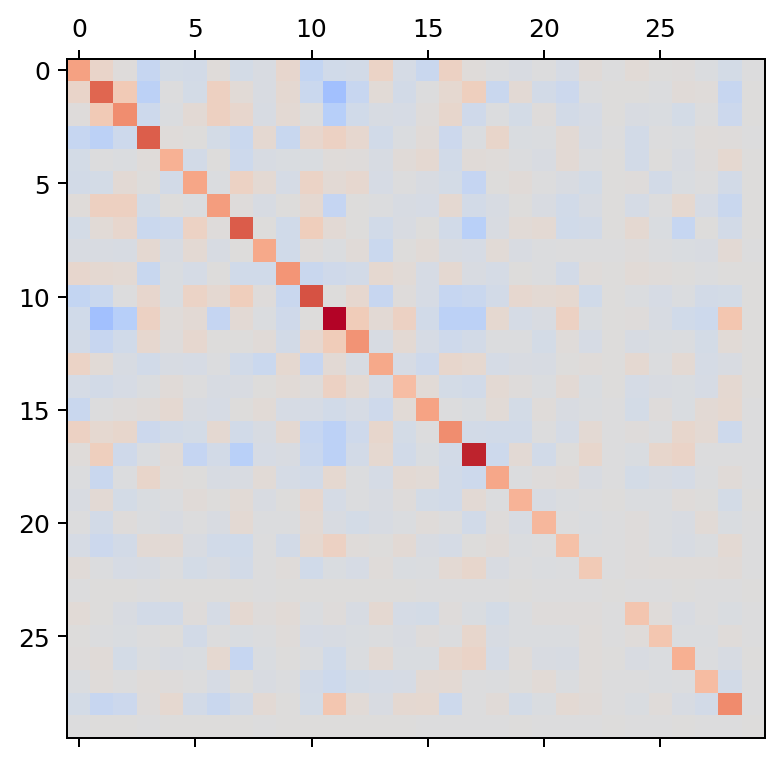

[7.82047827e-14 3.58732774e-04 2.00966437e-02 5.26310060e-01
 5.76037094e-01 6.40197704e-01 7.09057357e-01 7.31321447e-01
 7.95327749e-01 8.80929769e-01 9.03366180e-01 9.78376384e-01
 1.10163504e+00 1.18337292e+00 1.21506723e+00 1.27422785e+00
 1.48686380e+00 1.57399332e+00 1.65585927e+00 1.77815410e+00
 1.80648408e+00 1.94747243e+00 2.07630174e+00 2.34579994e+00
 2.63277988e+00 3.05618304e+00 3.39670864e+00 4.28681999e+00
 5.63175908e+00 7.92411801e+00]
bshift 1.5549222736167483 0.5695589630564122
const_conll 1.107357056369131 0.5663105613849699
coord_inv 1.139326671600242 0.8042759116721648
coref_conll 1.5015763828701383 0.8367827858588037
dep_ewt 1.3685723477064728 0.8301609375293462
dpr 1.2480672980034533 0.4016155254505321
dun_fst_pst 1.2097634412338234 0.5069666453652708
dun_go_pst 1.1523080861664055 0.5703551773672348
dun_rt_bnd 1.2335590732518138 0.5645249300060124
elan 1.8017765260143241 0.004052771653952858
epnp 1.8017765260143241 0.004052771653952858
first_fixation 1.8017765

In [3]:
full_cov = covariance_estimates_cov['sequence_all_bottleneck']['__all__']
diag = np.sqrt(np.diagonal(full_cov, axis1=1, axis2=2))
full_corr = full_cov / (np.expand_dims(diag, 1) * np.expand_dims(diag, 2))
vmax = np.max(np.abs(full_cov[0]))
render_subplot_artists([SubplotArtist(
    width=5, height=5, render_fn=lambda ax: matshow(ax, full_cov[0], cmap='coolwarm', vmin=-vmax, vmax=vmax))], dpi=180)
from scipy.linalg import eigvalsh
print(eigvalsh(full_cov[0]))
for split in covariance_estimates_cov['sequence_all_bottleneck']:
    if split == '__all__':
        continue
    split_cov = covariance_estimates_cov['sequence_all_bottleneck'][split]
    diag = np.sqrt(np.diagonal(split_cov, axis1=1, axis2=2))
    split_corr = split_cov / (np.expand_dims(diag, 1) * np.expand_dims(diag, 2))
#     vmax = np.max(np.abs(split_cov[0]))
#     render_subplot_artists([SubplotArtist(
#         width=5, height=5, render_fn=lambda ax: matshow(ax, split_cov[0], cmap='coolwarm', vmin=-vmax, vmax=vmax))], dpi=180)
    # print(split, np.max(np.abs(split_corr[0] - full_corr[0])))
    ratio = eigvalsh(split_cov[0]) / eigvalsh(full_cov[0])
    print(split, np.max(ratio), np.min(ratio))

In [4]:
def cached_weights():
    with np.load('model_weights.npz') as temp:
        ordered_names = temp['ordered_names']
        index_runs = temp['index_runs']
        weights = temp['weights']
    return ordered_names, index_runs, weights

ordered_names, index_runs, weights = cached_weights()

In [6]:
variation_name = 'fmri_raw_dds_direct'
statistics_spec = StatisticsSpec(regression_metric='r', classifier_metric='acc')

full_variation_results = compute_statistics_on_aggregated(
    paths, variation_name, statistics_spec)


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: 

In [4]:
alpha = 0.01

# group ERPs together, and group eye-tracking together
# for False Discovery Rate correction
fdr_groups = [
    {'elan', 'lan', 'n400', 'epnp', 'p600', 'pnp'},
    {'first_fixation', 'first_pass', 'right_bounded', 
     'go_past', 'word_first_fixation_duration', 
     'word_fixation_count', 'word_gaze_duration', 'word_go_past_time',
     'word_total_reading_time', 'dun_fst_pst', 'dun_go_pst', 'dun_rt_bnd'}]

stat_sig = dict()
for fdr_group in fdr_groups:
    # all the keys in fdr_groups are for scalar values
    p_values = np.array(list(full_variation_results[key].p_values for key in fdr_group))
    indicator_stat_sig, _ = fdr_correction(p_values / 2, alpha=alpha)
    for key, is_stat_sig in zip(fdr_group, indicator_stat_sig):
        # one-tailed
        is_stat_sig = is_stat_sig \
            and full_variation_results[key].model_mean > full_variation_results[key].baseline_mean
        stat_sig[key] = is_stat_sig

for key in full_variation_results:
    if key in stat_sig:  # we already did this as part of an fdr group
        continue
    if key.startswith('hp_fmri_'):
        continue
    assert np.prod(full_variation_results[key].p_values.shape) == 1
    # one-tailed
    is_sig = np.logical_and(
        full_variation_results[key].p_values / 2 <= alpha,
        full_variation_results[key].model_mean > full_variation_results[key].baseline_mean)
    stat_sig[key] = is_sig
    
for key in full_variation_results:
    if key.startswith('hp_fmri_'):
        continue
    print(key, stat_sig[key], full_variation_results[key].model_mean, full_variation_results[key].baseline_mean)

bshift True 0.60251953125 0.51841796875
const_conll True 0.5441796875 0.36671875
coord_inv False 0.52392578125 0.51841796875
coref_conll True 0.79837890625 0.7819921875
dep_ewt True 0.59830078125 0.11958984375
dpr False 0.5035356200527705 0.5013192612137205
dun_fst_pst True 0.41166526 0
dun_go_pst True 0.3942709 0
dun_rt_bnd True 0.44007114 0
elan True 0.42947334 0
epnp True 0.38757062 0
first_fixation True 0.7177223 0
first_pass True 0.7168586 0
go_past True 0.71991754 0
lan True 0.44915727 0
n400 True 0.37036002 0
ner_conll True 0.79216796875 0.19537109375
obj_num True 0.5890234375 0.5166796875
p600 True 0.43034852 0
pnp True 0.44540635 0
pos_conll True 0.61587890625 0.13216796875
reading_time True 0.16807404 0
right_bounded True 0.7190659 0
sem_eval True 0.5293359375 0.16271484375
sent_len True 0.42603515625 0.1873828125
sentiment True 0.63841796875 0.51375
somo False 0.51494140625 0.516171875
spr1_awareness True 0.9130859375 0.63427734375
spr1_change_of_location False 0.94564453125

In [54]:
volume_dict = OrderedDict()
for key in full_variation_results:
    if not key.startswith('hp_fmri_'):
        continue
    # use two-tailed here, because one-tailed can be misleading
    indicator_stat_sig, _ = fdr_correction(full_variation_results[key].p_values, alpha=alpha)
    values = np.squeeze(np.where(indicator_stat_sig, full_variation_results[key].model_mean, np.nan), axis=0)
    vmax = np.nanquantile(np.abs(values), 0.95)
    volume_dict[key[-1]] = make_volume(values, key[-1], cmap='coolwarm', vmin=-vmax, vmax=vmax)

cortex.webshow(volume_dict, open_browser=False)

/usr0/home/drschwar/src/bert_brain/bert_brain/false_discovery_rate.py:101: RuntimeWarning: invalid value encountered in less_equal
  indicator_alternative = p_values <= correction_factor * alpha


Started server on port 48190


<WebApp(Thread-6, started 139739933783808)>

Stopping server


In [77]:
fig, ax = make_figure(SubplotArtist(width=5, height=5), dpi=50)
for key in full_variation_results:
    if not key.startswith('hp_fmri_'):
        continue
    # use two-tailed here, because one-tailed can be misleading
    indicator_stat_sig, _ = fdr_correction(full_variation_results[key].p_values, alpha=alpha)
    indicator_stat_sig = np.squeeze(indicator_stat_sig, axis=0)
    values = np.squeeze(full_variation_results[key].model_mean, axis=0)[indicator_stat_sig]
    err = np.squeeze(full_variation_results[key].model_std, axis=0)[indicator_stat_sig]
    idx_sort = np.argsort(-values)
    values = values[idx_sort]
    err = err[idx_sort]
    h = ax.plot(values)
    c = h[0].get_color()
    ax.fill_between(np.arange(len(values)), values - err, values + err, color=c, alpha=0.05)
    ax.set_xscale('log')
ax.set_title('Pearson\'s correlation for voxels in fMRI tasks')
ax.set_ylabel('Pearson\'s correlation')
ax.set_xlabel('Voxel rank')
ax.axhline(0, color='black', linestyle='--')  

# fig.show()
fig.show('fmri_correlation_plots.pdf')

/usr0/home/drschwar/src/bert_brain/bert_brain/false_discovery_rate.py:101: RuntimeWarning: invalid value encountered in less_equal
  indicator_alternative = p_values <= correction_factor * alpha
/usr0/home/drschwar/src/bert_brain/bert_brain/false_discovery_rate.py:101: RuntimeWarning: invalid value encountered in less_equal
  indicator_alternative = p_values <= correction_factor * alpha
/usr0/home/drschwar/src/bert_brain/bert_brain/false_discovery_rate.py:101: RuntimeWarning: invalid value encountered in less_equal
  indicator_alternative = p_values <= correction_factor * alpha
/usr0/home/drschwar/src/bert_brain/bert_brain/false_discovery_rate.py:101: RuntimeWarning: invalid value encountered in less_equal
  indicator_alternative = p_values <= correction_factor * alpha
/usr0/home/drschwar/src/bert_brain/bert_brain/false_discovery_rate.py:101: RuntimeWarning: invalid value encountered in less_equal
  indicator_alternative = p_values <= correction_factor * alpha
/usr0/home/drschwar/src/b

0 bshift
1 const_conll
2 coord_inv
3 coref_conll
4 dep_ewt
5 dpr
6 dun_fst_pst
7 dun_go_pst
8 dun_rt_bnd
9 elan
10 epnp
11 first_fixation
12 first_pass
13 go_past
14 hp_fmri_F
15 hp_fmri_G
16 hp_fmri_H
17 hp_fmri_I
18 hp_fmri_J
19 hp_fmri_K
20 hp_fmri_L
21 hp_fmri_M
22 hp_fmri_N
23 lan
24 n400
25 ner_conll
26 obj_num
27 p600
28 pnp
29 pos_conll
30 reading_time
31 right_bounded
32 sem_eval
33 sent_len
34 sentiment
35 somo
36 spr1_awareness
37 spr1_change_of_location
38 spr1_change_of_state
39 spr1_changes_possession
40 spr1_created
41 spr1_destroyed
42 spr1_existed_after
43 spr1_existed_before
44 spr1_existed_during
45 spr1_exists_as_physical
46 spr1_instigation
47 spr1_location_of_event
48 spr1_makes_physical_contact
49 spr1_manipulated_by_another
50 spr1_predicate_changed_argument
51 spr1_sentient
52 spr1_stationary
53 spr1_volition
54 spr2_awareness
55 spr2_change_of_location
56 spr2_change_of_possession
57 spr2_change_of_state
58 spr2_change_of_state_continuous
59 spr2_changes_posse

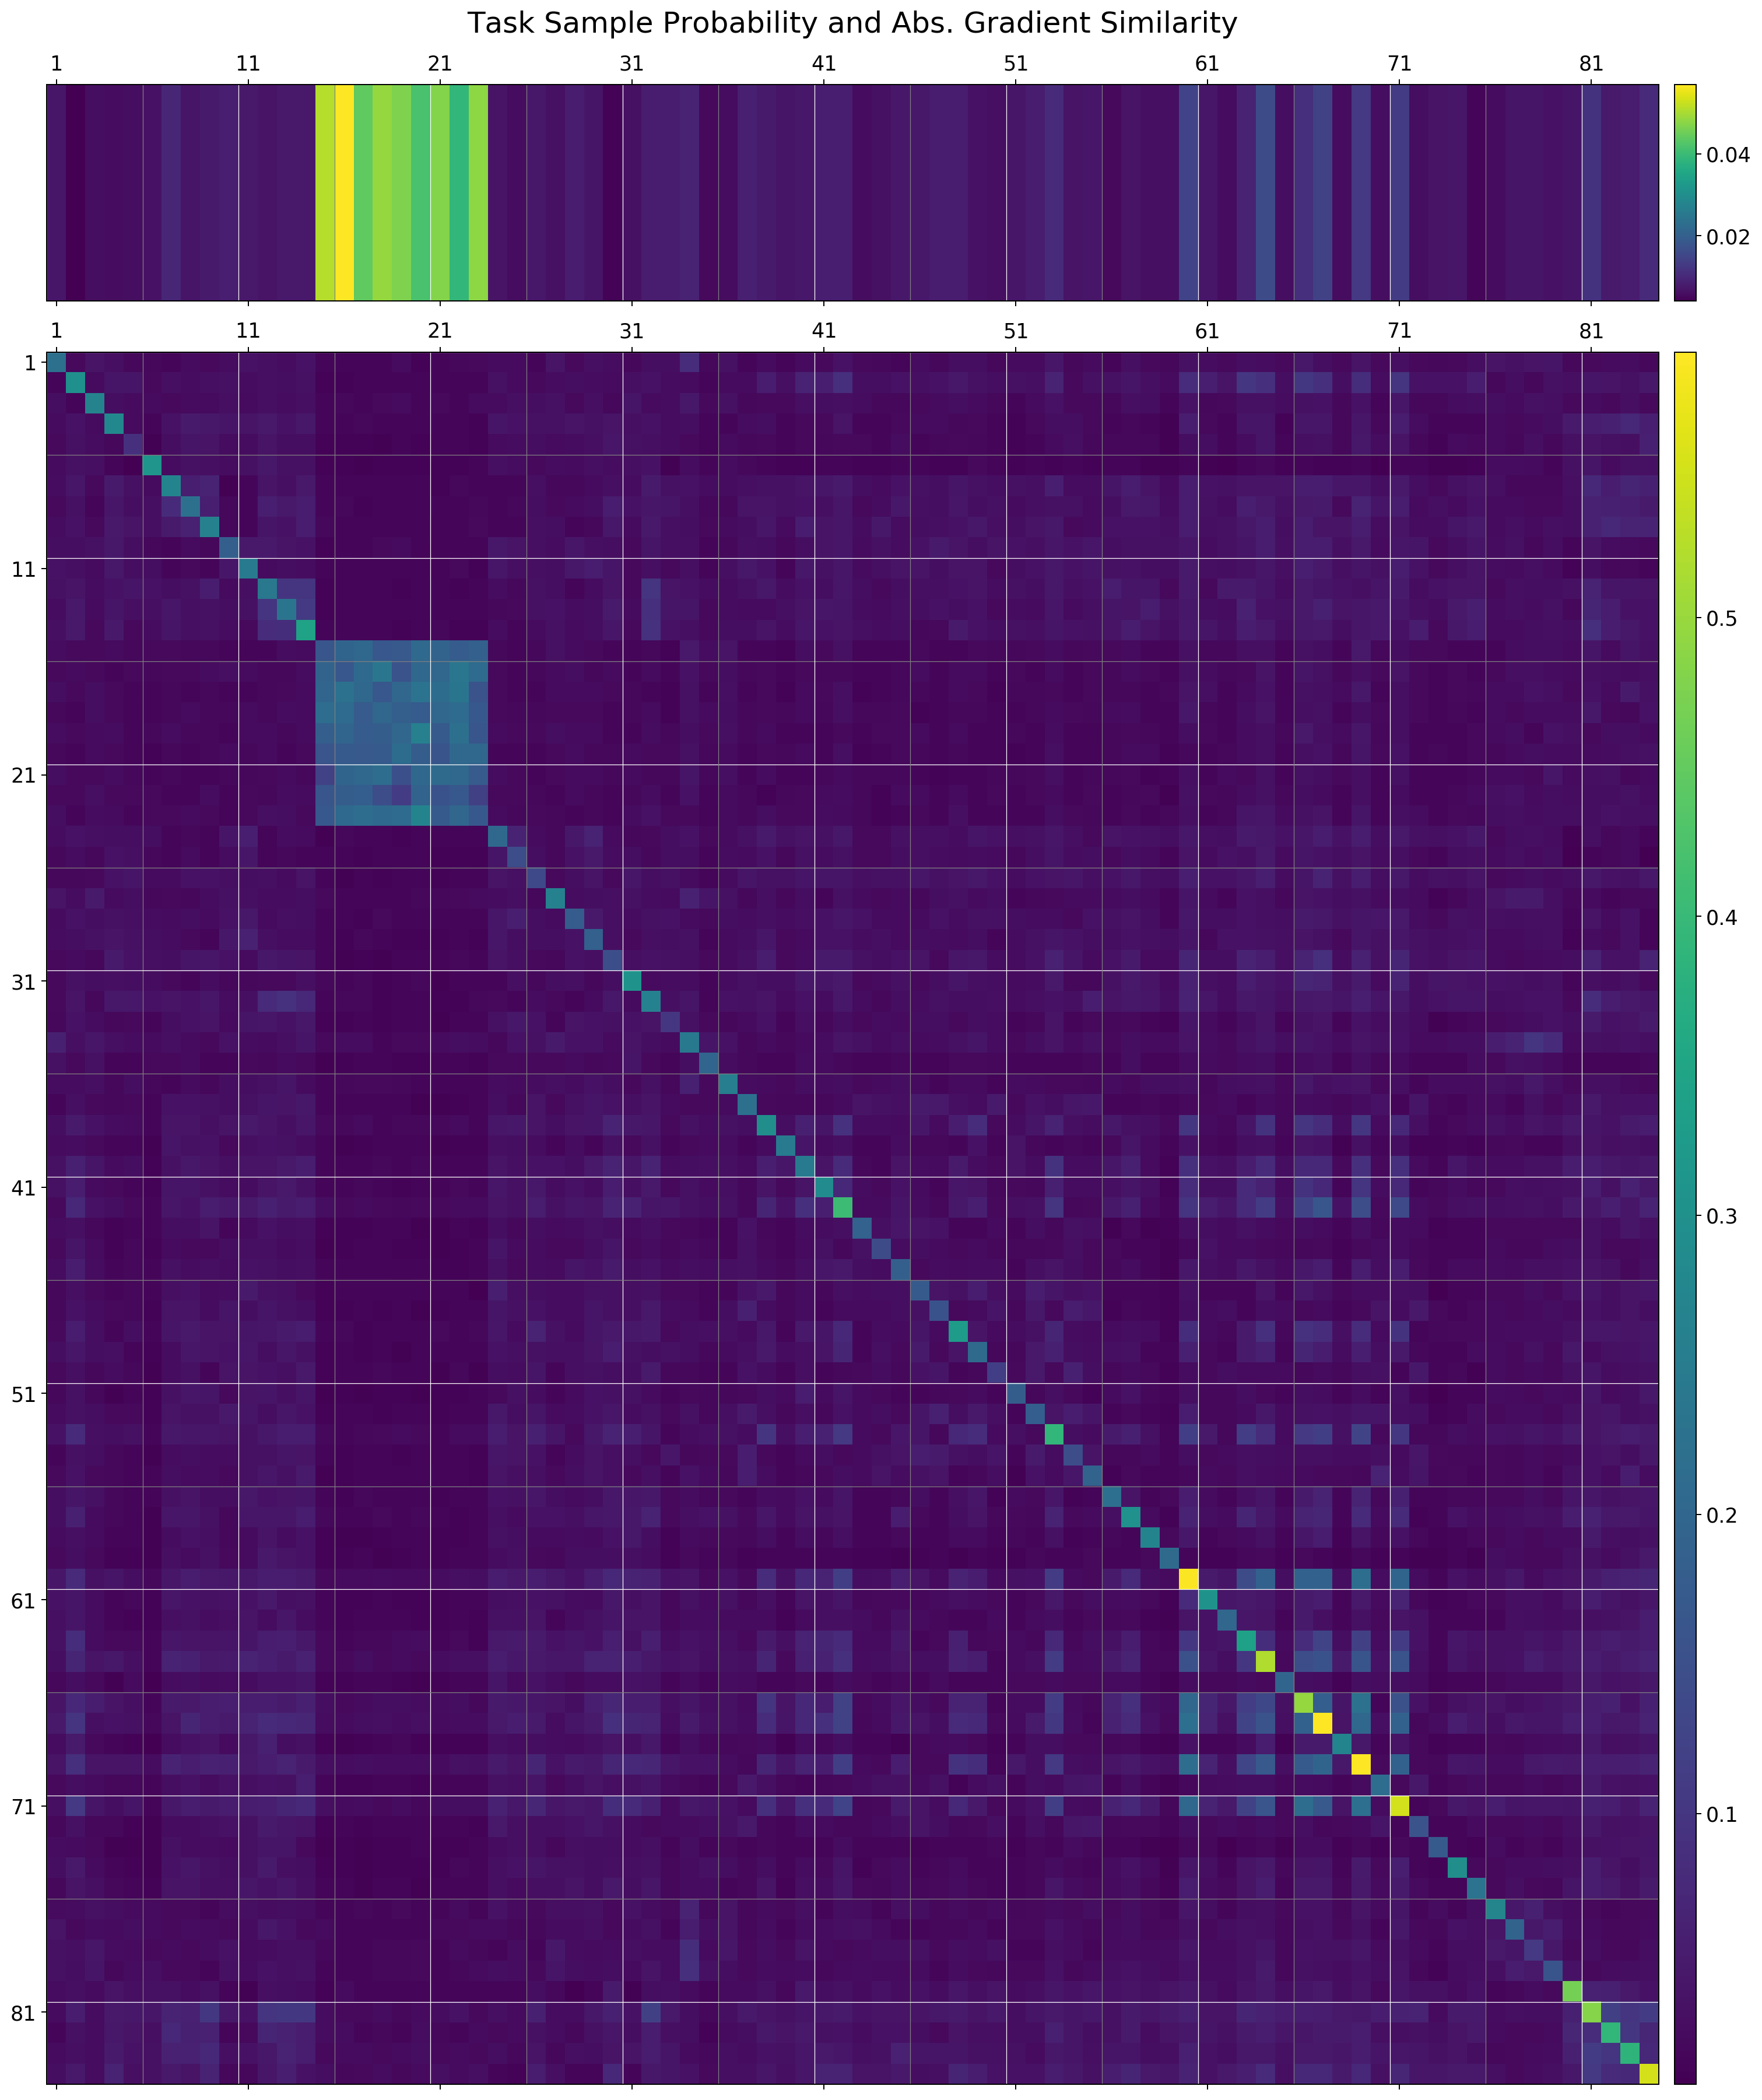

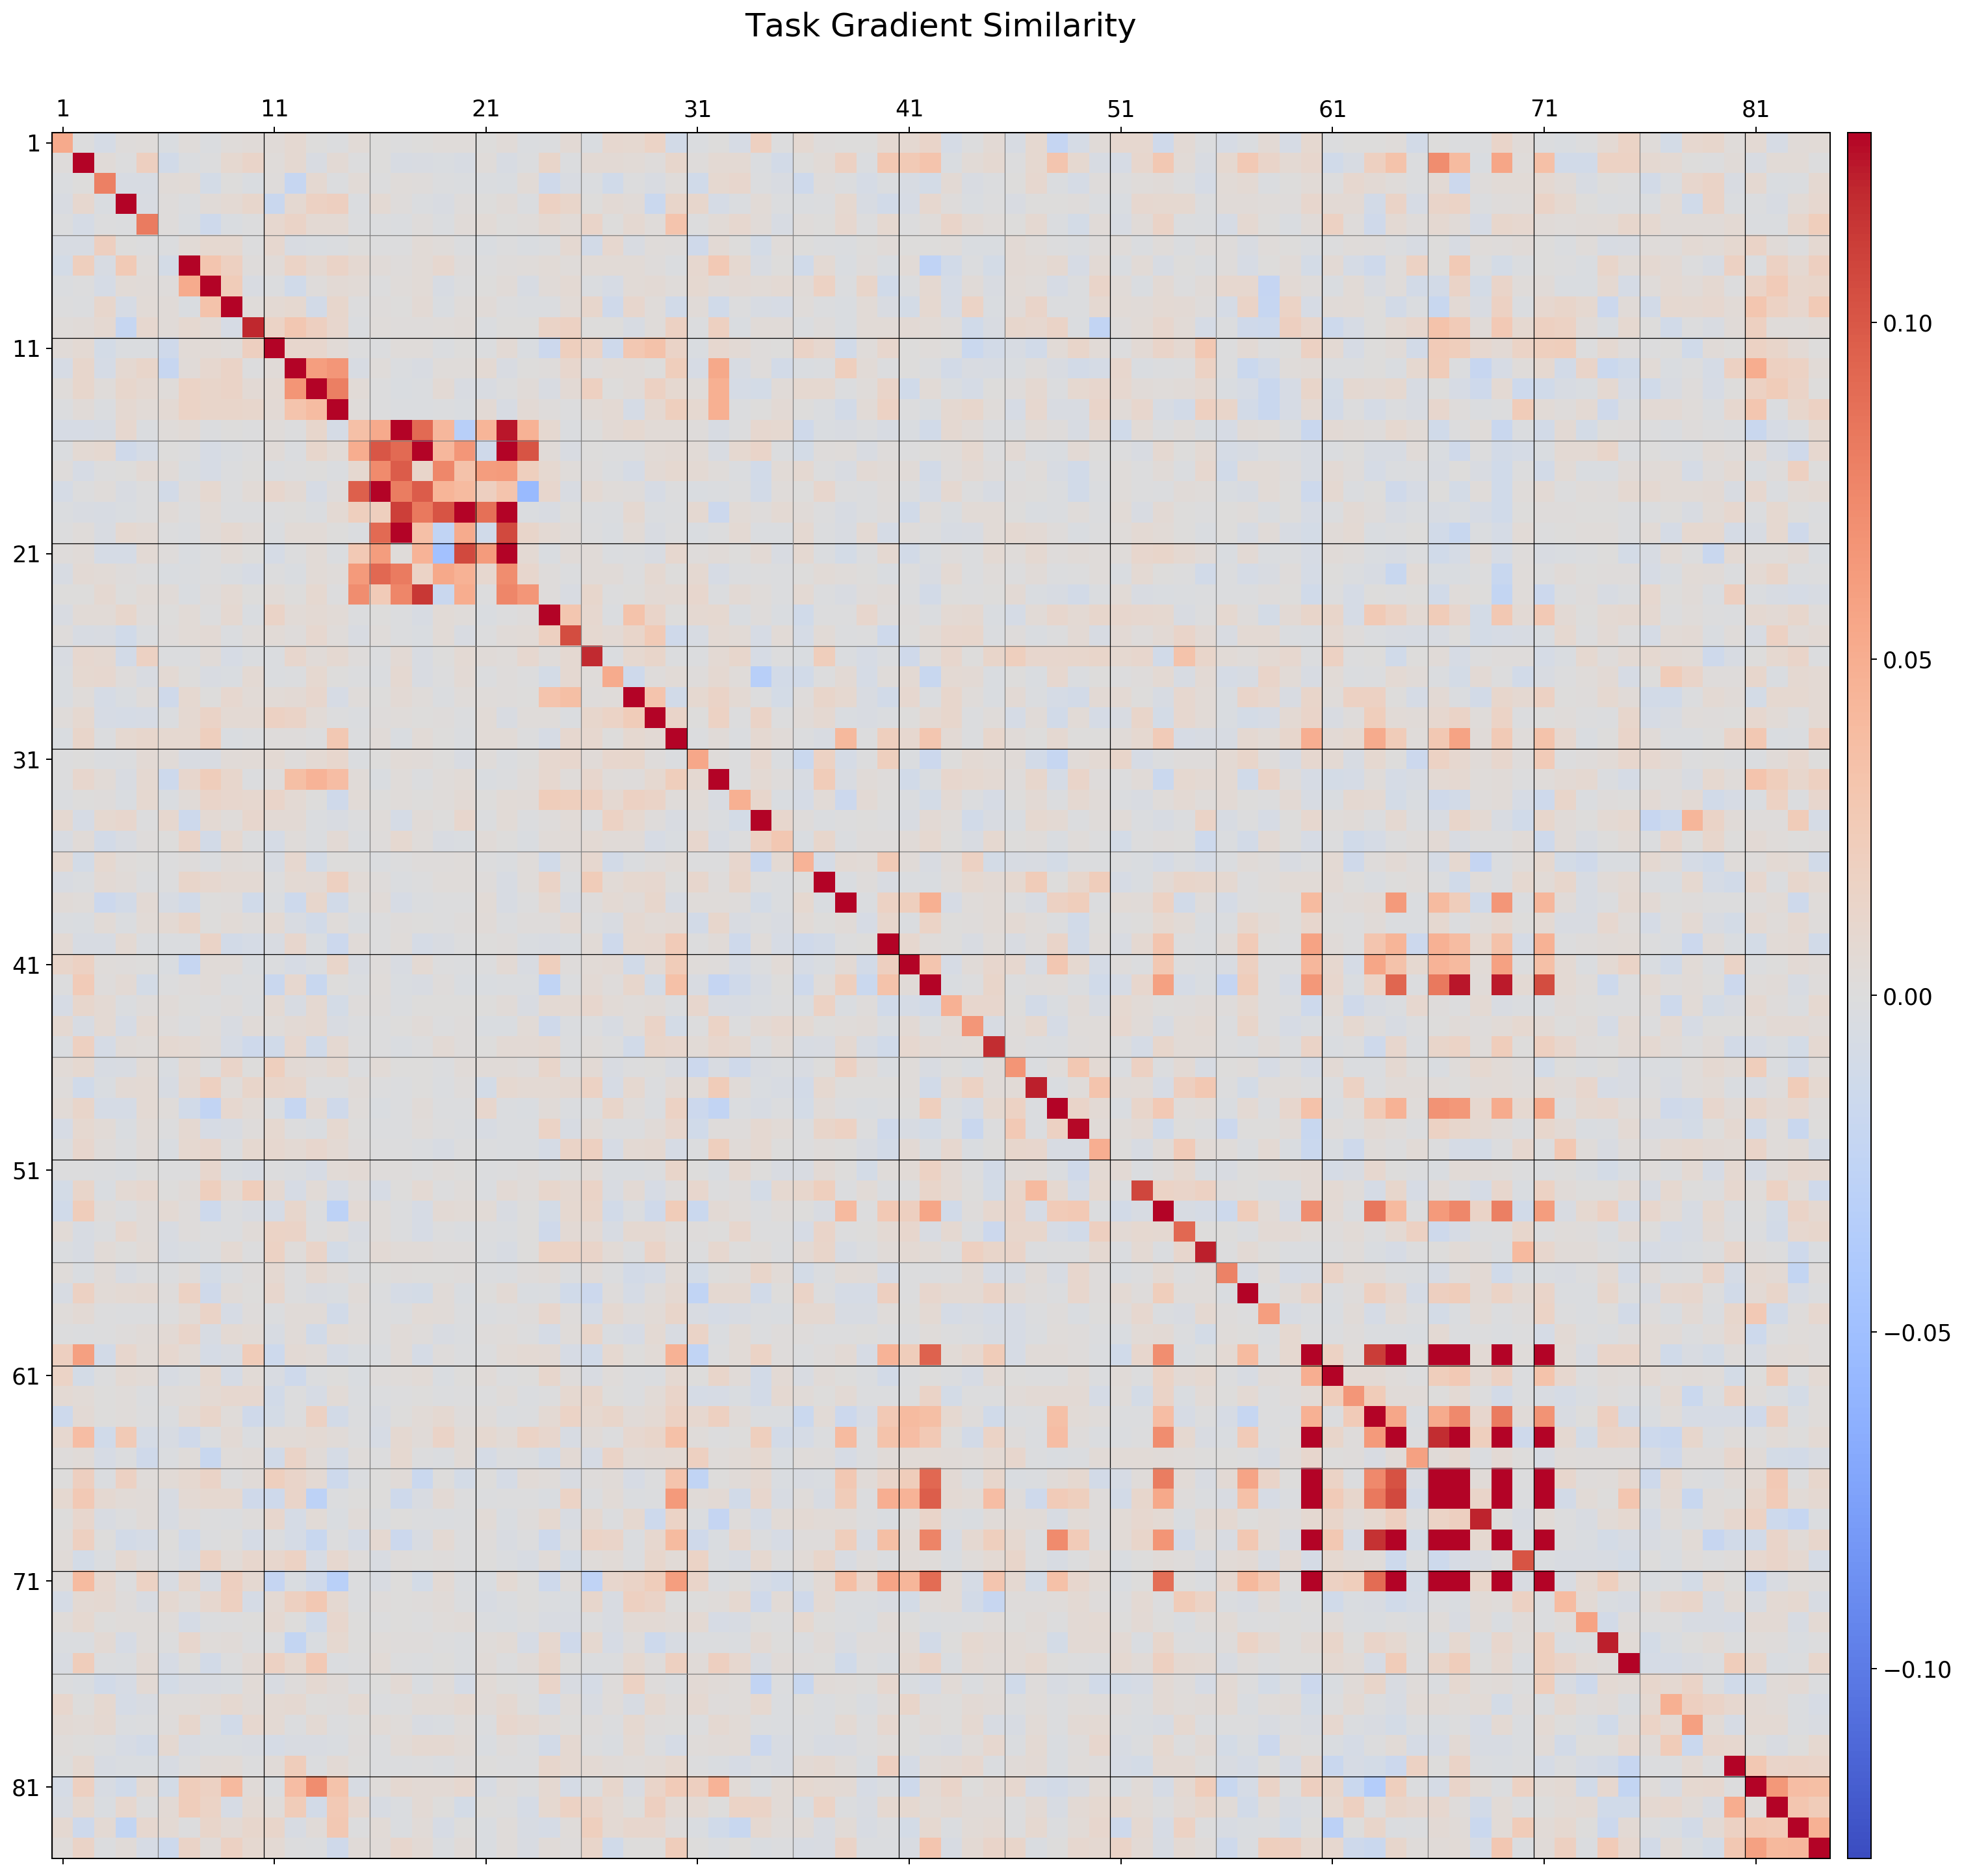

In [173]:
from scipy.special import softmax as scipy_softmax
from subplot_artist import SubplotArtistGrid
variation_name = 'fmri_raw_dds_direct'
_, settings = singleton_variation(variation_name)
task_sim = OrderedDict()
task_prob = OrderedDict()
for index_run in range(settings.num_runs):
    output_model_path = os.path.join(paths.model_path, variation_name, task_hash(settings), 'run_{}'.format(index_run))
    with open(os.path.join(output_model_path, 'task_sample_logits.txt'), 'rt') as task_weight_file:
        task_logits = OrderedDict(
            (line.split(':')[0].strip(), float(line.split(':')[1].strip())) 
            for line in task_weight_file if len(line.strip()) > 0)
        flat_logits = np.array(list(task_logits[task] for task in task_logits))
        probs = scipy_softmax(flat_logits)
        for key, prob in zip(task_logits, probs):
            if key not in task_prob:
                task_prob[key] = list()
            task_prob[key].append(prob)
    with open(os.path.join(output_model_path, 'pairwise_gradient_similarities.txt'), 'rt') as gradient_sim_file:
        for line in gradient_sim_file:
            if len(line.strip()) == 0:
                continue
            tasks, sim_str = line.split(':')
            t1, t2 = tasks.split(',')
            t1 = t1.strip()
            t2 = t2.strip()
            sim = float(sim_str.strip())
            if t1 not in task_sim:
                task_sim[t1] = OrderedDict()
            if t2 not in task_sim[t1]:
                task_sim[t1][t2] = list()
            task_sim[t1][t2].append(sim)
all_tasks = set()
all_tasks.update(task_prob)
all_tasks.update(task_sim)
for k in task_sim:
    all_tasks.update(task_sim[k])
all_tasks = list(sorted(all_tasks))
task_sim_mat = np.full((len(all_tasks), len(all_tasks)), np.nan)
abs_task_sim_mat = np.full_like(task_sim_mat, np.nan)
task_prob_vec = np.full(len(all_tasks), np.nan)
task_prob_mat = np.full((len(task_prob[all_tasks[0]]), len(all_tasks)), np.nan)
for i in range(len(all_tasks)):
    print(i, all_tasks[i])
    task_prob_vec[i] = np.mean(task_prob[all_tasks[i]])
    task_prob_mat[:, i] = np.array(task_prob[all_tasks[i]])
    for j in range(len(all_tasks)):
        values = task_sim[all_tasks[i]][all_tasks[j]]
        task_sim_mat[i, j] = np.nanmean(values)
        abs_task_sim_mat[i, j] = np.nanmean(np.abs(values))

grid = SubplotArtistGrid(num_columns=2, num_rows=2)
locations = dict()
counts = dict()

prob_ca = ColorbarArtist(width=0.2, height=2)
grid[0, 1] = prob_ca
prob_a = SubplotArtist(
    width=15, height=2, colorbar_artist=prob_ca,
    render_fn=lambda ax: matshow(ax, np.expand_dims(task_prob_vec, 0), cmap='viridis'))
grid[0, 0] = prob_a
locations[prob_a] = 0, 0
counts[prob_a] = len(abs_task_sim_mat)

colorbar_artist = ColorbarArtist(width=0.2, height=16)
grid[1, 1] = colorbar_artist
artist = SubplotArtist(
    width=15, height=16, 
    render_fn=lambda ax: matshow(ax, abs_task_sim_mat, cmap='viridis'), colorbar_artist=colorbar_artist)
grid[1, 0] = artist
locations[artist] = 1, 0
counts[artist] = len(abs_task_sim_mat)

fig, axes = grid.make_figure(dpi=180)
for artist in axes:
    artist.render(axes[artist])
    if artist == colorbar_artist or artist == prob_ca:
        axes[artist].tick_params(labelsize=14)
        continue
    if locations[artist][0] == 0 and locations[artist][1] == 0:
        axes[artist].set_title('Task Sample Probability and Abs. Gradient Similarity', y=1.2, fontsize=20)
        
    grid_lines = np.arange(0, counts[artist] + 1, 5)
    ticks = np.array(list(g for i, g in enumerate(grid_lines) if i % 2 == 0))
    
    axes[artist].set_xticks(ticks)
    axes[artist].set_xticklabels(ticks + 1)
    if artist == prob_a:
        axes[artist].set_yticks([])
    else:
        axes[artist].set_yticks(ticks)
        axes[artist].set_yticklabels(ticks + 1)
    axes[artist].tick_params(labelsize=14)
    
    for i, g in enumerate(grid_lines):
        grid_color = 'white' if i % 2 == 0 else 'gray'
        # grid_color='black'
        line_width = 0.5
        if artist != prob_a:
            axes[artist].axhline(g - 0.5, color=grid_color, linewidth=line_width)
        axes[artist].axvline(g - 0.5, color=grid_color, linewidth=line_width)
        
fig.show(is_tight_layout=True)
# fig.show(output_figure_path='task_prob_abs_grad_sim.png', is_tight_layout=True)

grid = SubplotArtistGrid(num_columns=2, num_rows=1)
locations = dict()
counts = dict()

colorbar_artist = ColorbarArtist(width=0.2, height=16)
grid[0, 1] = colorbar_artist
vmax = np.quantile(np.abs(task_sim_mat), 0.99)
artist = SubplotArtist(
    width=15, height=16, 
    render_fn=lambda ax: matshow(ax, task_sim_mat, cmap='coolwarm', vmin=-vmax, vmax=vmax), colorbar_artist=colorbar_artist)
grid[0, 0] = artist
locations[artist] = 0, 0
counts[artist] = len(task_sim_mat)

fig, axes = grid.make_figure(dpi=180)
for artist in axes:
    artist.render(axes[artist])
    if artist == colorbar_artist or artist == prob_ca:
        axes[artist].tick_params(labelsize=14)
        continue
    if locations[artist][0] == 0 and locations[artist][1] == 0:
        axes[artist].set_title('Task Gradient Similarity', y=1.05, fontsize=20)
        
    grid_lines = np.arange(0, counts[artist] + 1, 5)
    ticks = np.array(list(g for i, g in enumerate(grid_lines) if i % 2 == 0))
    
    axes[artist].set_xticks(ticks)
    axes[artist].set_xticklabels(ticks + 1)
    if artist == prob_a:
        axes[artist].set_yticks([])
    else:
        axes[artist].set_yticks(ticks)
        axes[artist].set_yticklabels(ticks + 1)
    axes[artist].tick_params(labelsize=14)
    
    for i, g in enumerate(grid_lines):
        grid_color = 'black' if i % 2 == 0 else 'gray'
        # grid_color='black'
        line_width = 0.5
        if artist != prob_a:
            axes[artist].axhline(g - 0.5, color=grid_color, linewidth=line_width)
        axes[artist].axvline(g - 0.5, color=grid_color, linewidth=line_width)
        
fig.show(is_tight_layout=True)
# fig.show(output_figure_path='task_grad_sim.png', is_tight_layout=True)

grid = SubplotArtistGrid(num_columns=2, num_rows=1)
locations = dict()
counts = dict()

colorbar_artist = ColorbarArtist(width=0.2, height=16)
grid[0, 1] = colorbar_artist
artist = SubplotArtist(
    width=15, height=16, 
    render_fn=lambda ax: matshow(ax, task_prob_mat, cmap='viridis'), colorbar_artist=colorbar_artist)
grid[0, 0] = artist
locations[artist] = 0, 0
counts[artist] = task_prob_mat.shape[1]

fig, axes = grid.make_figure(dpi=180)
for artist in axes:
    artist.render(axes[artist])
    if artist == colorbar_artist:
        axes[artist].tick_params(labelsize=14)
        continue
    if locations[artist][0] == 0 and locations[artist][1] == 0:
        axes[artist].set_title('Task Sample Probability Per Model Initialization', y=1.05, fontsize=20)
        
    grid_lines = np.arange(0, counts[artist] + 1, 5)
    ticks = np.array(list(g for i, g in enumerate(grid_lines) if i % 2 == 0))
    
    axes[artist].set_xticks(ticks)
    axes[artist].set_xticklabels(ticks + 1)
    axes[artist].set_yticks([])
    axes[artist].tick_params(labelsize=14)
    
    for i, g in enumerate(grid_lines):
        grid_color = 'white' if i % 2 == 0 else 'gray'
        # grid_color='black'
        line_width = 0.5
        axes[artist].axvline(g - 0.5, color=grid_color, linewidth=line_width)
        
# fig.show(is_tight_layout=True)
fig.show(output_figure_path='task_sample_prob_variation.png', is_tight_layout=True)

In [5]:
variation_name = 'fmri_raw_dds_direct'
statistics_spec = StatisticsSpec(regression_metric='r', classifier_metric='acc')
# group ERPs together, and group eye-tracking together
# for False Discovery Rate correction
fdr_groups = [
    {'elan', 'lan', 'n400', 'epnp', 'p600', 'pnp'},
    {'first_fixation', 'first_pass', 'right_bounded', 
     'go_past', 'word_first_fixation_duration', 
     'word_fixation_count', 'word_gaze_duration', 'word_go_past_time',
     'word_total_reading_time', 'dun_fst_pst', 'dun_go_pst', 'dun_rt_bnd'}]



def group_fmri(ordered_names):
    groups = OrderedDict()
    for i, name in enumerate(ordered_names):
        if name.startswith('hp_fmri_'):
            key = name[:name.index('.')]
            if key not in groups:
                groups[key] = list()
            groups[key].append((i, name))
            
    for key in groups:
        yield key, groups[key]
        
        
def bootstrap_samples(num_samples=100, alpha=0.01):
    samples = list()
    indicator_non_fmri = None
    indicator_fmri = OrderedDict()
    
    name_to_non_fmri_index = dict()
    index = 0
    for name in ordered_names:
        if name.startswith('hp_fmri_'):
            continue
        if name.endswith('.span0') or name.endswith('.span1'):
            name = name[:-len('.span0')]
        if name in name_to_non_fmri_index:
            if isinstance(name_to_non_fmri_index[name], tuple):
                name_to_non_fmri_index[name] = name_to_non_fmri_index[name] + (index,)
            else:
                name_to_non_fmri_index[name] = (name_to_non_fmri_index[name], index)
        else:
            name_to_non_fmri_index[name] = index
        index += 1
    num_non_fmri_index = index
    
    full_variation_results = compute_statistics_on_aggregated(
        paths, variation_name, statistics_spec, class_wise='inherit', keep_all=True)
    
    for _ in trange(num_samples):
        indices_sample_runs = np.random.choice(len(weights), len(weights))
        samples.append(indices_sample_runs)

        variation_results = OrderedDict(
            (k, full_variation_results[k].resample(indices_sample_runs)) for k in full_variation_results)

        stat_sig_done = set()
        stat_sig = np.full(num_non_fmri_index, False)
        for fdr_group in fdr_groups:
            # all the keys in fdr_groups are for scalar values
            p_values = np.array(list(variation_results[key].p_values for key in fdr_group))
            indicator_stat_sig, _ = fdr_correction(p_values / 2, alpha=alpha)
            for key, is_stat_sig in zip(fdr_group, indicator_stat_sig):
                # one-tailed
                is_stat_sig = is_stat_sig \
                    and variation_results[key].model_mean > variation_results[key].baseline_mean
                index = name_to_non_fmri_index[key]
                stat_sig_done.add(key)
                if isinstance(index, tuple):
                    for i in index:
                        stat_sig[i] = is_stat_sig
                else:
                    stat_sig[index] = is_stat_sig

        for key in variation_results:
            if key in stat_sig_done:  # we already did this as part of an fdr group
                continue
            if key.startswith('hp_fmri_'):
                continue
            assert np.prod(variation_results[key].p_values.shape) == 1
            # one-tailed
            is_sig = np.logical_and(
                variation_results[key].p_values / 2 <= alpha,
                variation_results[key].model_mean > variation_results[key].baseline_mean)
            index = name_to_non_fmri_index[key]
            if isinstance(index, tuple):
                for i in index:
                    stat_sig[i] = is_sig
            else:
                stat_sig[index] = is_sig
                
        if indicator_non_fmri is None:
            indicator_non_fmri = stat_sig
        else:
            indicator_non_fmri = np.logical_and(indicator_non_fmri, stat_sig)
                
        # find similarity from fMRI
        for key in variation_results:
            if not key.startswith('hp_fmri_'):
                continue
            
            indicator_stat_sig, _ = fdr_correction(variation_results[key].p_values / 2, alpha=alpha)
            indicator_stat_sig = np.squeeze(np.logical_and(
                indicator_stat_sig,
                variation_results[key].model_mean > variation_results[key].baseline_mean), axis=0)
            
            if key not in indicator_fmri:
                indicator_fmri[key] = indicator_stat_sig
            else:
                indicator_fmri[key] = np.logical_and(indicator_fmri[key], indicator_stat_sig)
                
    return samples, indicator_fmri, indicator_non_fmri
     
    
def metric_transform(metric, weight_transform, weights):
    is_metric_internal = False
    metric_suffix = None
    for internal_transform_metric in [
            'covariance_scaled_correlation', 
            'covariance_scaled_cosine']:
        if metric.startswith(internal_transform_metric):
            is_metric_internal = True
            metric_suffix = metric[len(internal_transform_metric):]
            break
    if weight_transform == 'sign_norm':
        if is_metric_internal:
            if len(metric_suffix) == 0:
                m = metric + '_sign_norm'
                print('metric change: {}'.format(m))
                return m, weights
            elif metric_suffix != '_sign_norm':
                raise ValueError('Incompatible metric name and weight transform')
            return metric, weights
        else:
            # use the larger of the sum of the negative and positive weights to decide polarity
            return metric, np.sign(np.sum(weights, axis=-1, keepdims=True)) * weights
    elif weight_transform == 'abs':
        if is_metric_internal:
            if len(metric_suffix) == 0:
                m = metric + '_abs'
                print('metric change: {}'.format(m))
                return m, weights
            elif metric_suffix != '_abs':
                raise ValueError('Incompatible metric name and weight transform')
            return metric, weights
        else:
            return metric, np.abs(weights)
    elif weight_transform is not None:
        raise ValueError('Unknown weight_transform: {}'.format(weight_transform))
    return metric, weights


        
def compute_similarities(
        bootstrap_sample_indices,
        indicator_fmri,
        indicator_non_fmri,
        weights,
        ordered_names,
        metric='cosine',
        use_abs=False,
        num_bootstrap_samples=100, 
        alpha=0.01,
        num_fmri_clusters=3,
        weight_transform=None,
        cov=None):
    
    fmri_weights = OrderedDict()
    for fmri_key, fmri_index_names in group_fmri(ordered_names):
        indices_fmri = [i for i, name in fmri_index_names]
        fmri_weights[fmri_key] = weights[:, indices_fmri]
    
    indices_non_fmri = [i for i, name in enumerate(ordered_names) if not name.startswith('hp_fmri_')]
    non_fmri_weights = weights[:, indices_non_fmri]
    assert(non_fmri_weights.shape[1] == len(indicator_non_fmri))
    # remove tasks that are not stat sig better than baseline
    non_fmri_weights = non_fmri_weights[:, indicator_non_fmri]
    
    metric, non_fmri_weights = metric_transform(metric, weight_transform, non_fmri_weights)
    # compute similarity within run
    non_fmri_similarity_all = batch_psim(non_fmri_weights, metric=metric, cov=cov)
    if use_abs:
        non_fmri_similarity_all = np.abs(non_fmri_similarity_all)

    fmri_similarity_all = OrderedDict()
    # find similarity from fMRI
    for key in tqdm(fmri_weights, desc='fMRI similarity'):
        fmri_weights_subj = fmri_weights[key]
        assert(fmri_weights_subj.shape[1] == len(indicator_fmri[key]))
        # remove tasks that are not stat sig better than baseline
        fmri_weights_subj = fmri_weights_subj[:, indicator_fmri[key]]
        metric, fmri_weights_subj = metric_transform(metric, weight_transform, fmri_weights_subj)
        fmri_similarity_all[key] = batch_csim(fmri_weights_subj, non_fmri_weights, metric=metric, cov=cov)
        if use_abs:
            fmri_similarity_all[key] = np.abs(fmri_similarity_all[key])
    
    bootstrap_fmri_similarity = OrderedDict()
    for key in fmri_similarity_all:
        bootstrap_fmri_similarity[key] = np.full(
            (num_bootstrap_samples,) + fmri_similarity_all[key].shape[1:], np.nan, 
            dtype=fmri_similarity_all[key].dtype)
        
    bootstrap_non_fmri_similarity = np.full(
        (num_bootstrap_samples,) + non_fmri_similarity_all.shape[1:], np.nan, dtype=non_fmri_similarity_all.dtype)

    for i_sample, indices_sample_runs in tqdm(enumerate(bootstrap_sample_indices, desc='bootstrap')):
        bootstrap_non_fmri_similarity[i_sample] = indexed_mean(indices_sample_runs, non_fmri_similarity_all)
        for key in fmri_similarity_all:
            bootstrap_fmri_similarity[key][i_sample] = indexed_mean(indices_sample_runs, fmri_similarity_all[key])
        
    full_non_fmri_similarity = np.full(
        bootstrap_non_fmri_similarity.shape[:-1] + (len(indicator_non_fmri),), np.nan, 
        dtype=bootstrap_non_fmri_similarity.dtype)
    full_non_fmri_similarity[..., indicator_non_fmri] = bootstrap_non_fmri_similarity
    bootstrap_non_fmri_similarity = full_non_fmri_similarity
    full_non_fmri_similarity = np.full(
        (bootstrap_non_fmri_similarity.shape[0], len(indicator_non_fmri)) + bootstrap_non_fmri_similarity.shape[2:], 
        np.nan, dtype=bootstrap_non_fmri_similarity.dtype)
    full_non_fmri_similarity[:, indicator_non_fmri] = bootstrap_non_fmri_similarity
    bootstrap_non_fmri_similarity = full_non_fmri_similarity

    return bootstrap_fmri_similarity, bootstrap_non_fmri_similarity 
        
        
def cluster_fmri(bootstrap_fmri_similarity, indicator_fmri, num_clusters=3):
    bootstrap_means = np.concatenate(
        list(np.mean(bootstrap_fmri_similarity[k], axis=0) for k in bootstrap_fmri_similarity)) 
    clusterer = KMeans(n_clusters=num_clusters, n_init=100)
    labels = clusterer.fit_predict(bootstrap_means)
    labels = np.split(
        labels, np.cumsum(list(bootstrap_fmri_similarity[k].shape[1] for k in bootstrap_fmri_similarity))[:-1])
    by_label = OrderedDict((lbl, list()) for lbl in range(num_clusters))
    for k_labels, k in zip(labels, bootstrap_fmri_similarity):
        for label in np.unique(k_labels):
            by_label[label].append(np.reshape(
                bootstrap_fmri_similarity[k][:, k_labels == label], (-1, bootstrap_fmri_similarity[k].shape[-1])))

    for label in by_label:
        by_label[label] = np.concatenate(by_label[label])

    label_means = np.array(list(np.nanmean(by_label[label], axis=0) for label in by_label))
    label_std = np.array(list(np.nanstd(by_label[label], axis=0) for label in by_label))

    return label_means, label_std, labels


bootstrap_sample_indices, indicator_fmri, indicator_non_fmri = bootstrap_samples(num_samples=100, alpha=0.01)
for weight_transform in ['sign_norm', 'abs']:  # [None, 'sign_norm', 'abs']:
    print('processing {}'.format(weight_transform))
    bootstrap_fmri, bootstrap_non_fmri = compute_similarities(
        bootstrap_sample_indices, indicator_fmri, indicator_non_fmri, np.asarray(weights, dtype=np.float64), ordered_names, 
        metric='covariance_scaled_cosine', use_abs=True, weight_transform=weight_transform, 
        cov=np.asarray(full_cov, dtype=np.float64))
    label_means, label_std, labels = cluster_fmri(bootstrap_fmri, indicator_fmri, num_clusters=3)
    combined_mean = np.concatenate([label_means, np.mean(bootstrap_non_fmri[..., indicator_non_fmri], axis=0)])
    combined_std = np.concatenate([label_std, np.std(bootstrap_non_fmri[..., indicator_non_fmri], axis=0)])

    bootstrap_result_dict = dict()
    bootstrap_result_dict['feature_names_non_fmri'] = list(n for n in ordered_names if not n.startswith('hp_fmri_'))
    bootstrap_result_dict['indicator_stat_sig_non_fmri'] = indicator_non_fmri
    bootstrap_result_dict['mean_similarities'] = combined_mean
    bootstrap_result_dict['std_similarities'] = combined_std
    for k_labels, k in zip(labels, indicator_fmri):
        assert(np.sum(indicator_fmri[k]) == len(k_labels))
        bootstrap_result_dict['labels_{}'.format(k)] = k_labels
        bootstrap_result_dict['stat_sig_{}'.format(k)] = indicator_fmri[k]
        bootstrap_result_dict['fmri_mean_similarities_{}'.format(k)] = np.mean(bootstrap_fmri[k], axis=0)
        bootstrap_result_dict['fmri_std_similarities_{}'.format(k)] = np.std(bootstrap_fmri[k], axis=0)

    np.savez('bootstrap_similarities_abs_cov_scaled_cosine{}.npz'.format(
        '' if weight_transform is None else '_{}'.format(weight_transform)), **bootstrap_result_dict)

/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr0/home/drschwar/src/bert_brain/bert_brain/false_discovery_rate.py:101: RuntimeWarning: invalid value encountered in less_equal
  indicator_alternative = p_values <= correction_factor * alpha



processing sign_norm
metric change: covariance_scaled_cosine_sign_norm


/usr0/home/drschwar/src/bert_brain/bert_brain/common/numba_utilities.py:266: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  z = _sign_norm(_cov_transform(x[i], cov[i]))


MemoryError: Unable to allocate 4.74 GiB for an array with shape (100, 13677, 465) and data type float64

In [25]:
most_reliable_voxel_means = OrderedDict()
most_reliable_voxel_std_err = OrderedDict()
most_reliable_voxel_indices = OrderedDict()
num_per_participant = 10
for k in tqdm(bootstrap_fmri):
    bootstrap_std_err = np.std(bootstrap_fmri[k], axis=0)
    bootstrap_mean = np.mean(bootstrap_fmri[k], axis=0)
    score = np.mean(bootstrap_std_err, axis=1)
    most_reliable = np.argsort(score)[:num_per_participant]
    most_reliable_voxel_means[k] = list()
    most_reliable_voxel_std_err[k] = list()
    most_reliable_voxel_indices[k] = list()
    for idx in most_reliable:
        tmp = np.full(np.sum(indicator_fmri[k]), False)
        tmp[idx] = True
        tmp2 = np.full(indicator_fmri[k].shape, False)
        tmp2[indicator_fmri[k]] = tmp
        true_idx = np.where(tmp2)[0].item()
        most_reliable_voxel_indices[k].append(true_idx)
        most_reliable_voxel_means[k].append(bootstrap_mean[idx])
        most_reliable_voxel_std_err[k].append(bootstrap_std_err[idx])
for k in most_reliable_voxel_means:
    most_reliable_voxel_means[k] = np.array(most_reliable_voxel_means[k])
    most_reliable_voxel_std_err[k] = np.array(most_reliable_voxel_std_err[k])
    most_reliable_voxel_indices[k] = np.array(most_reliable_voxel_indices[k])

(3, 467)


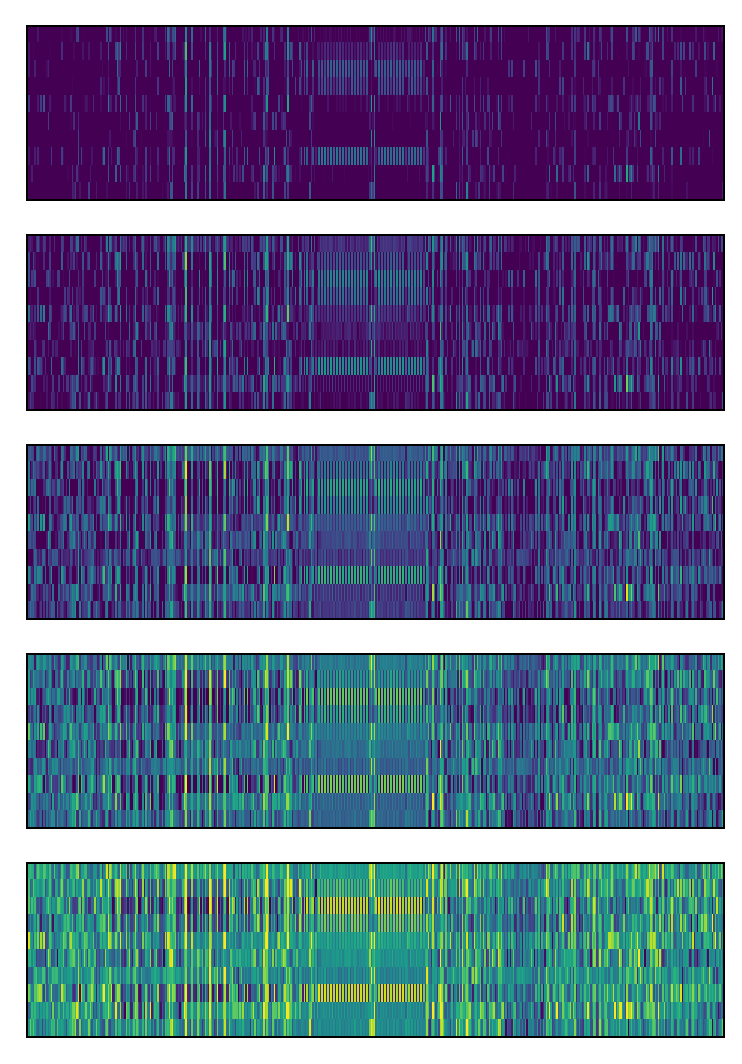

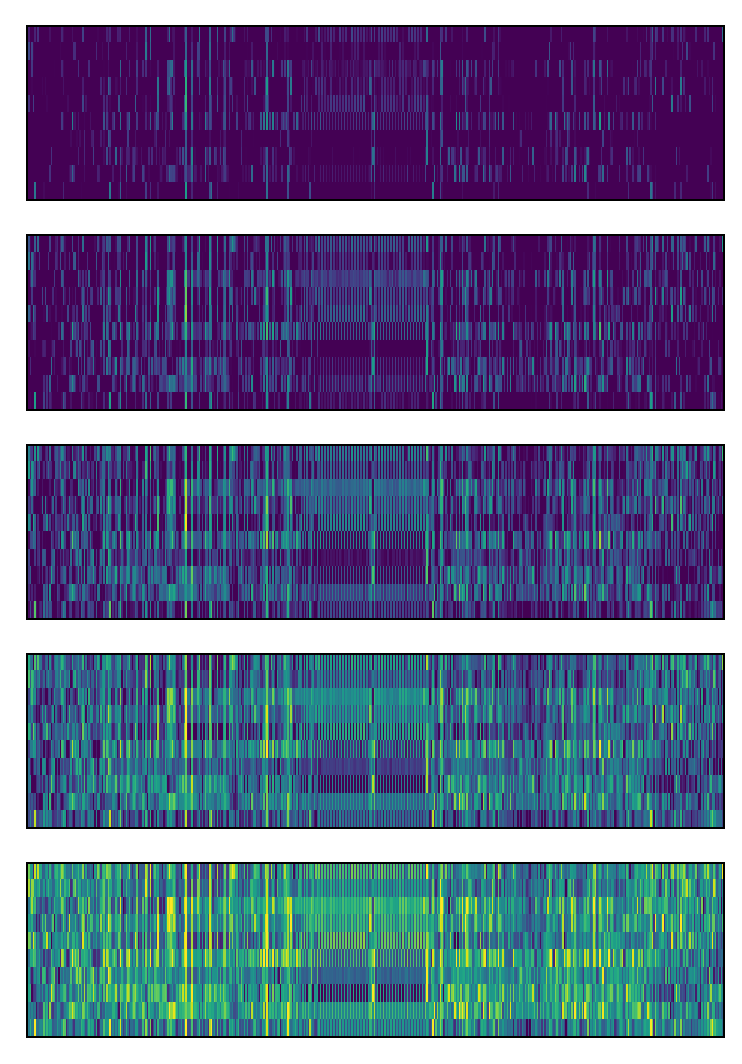

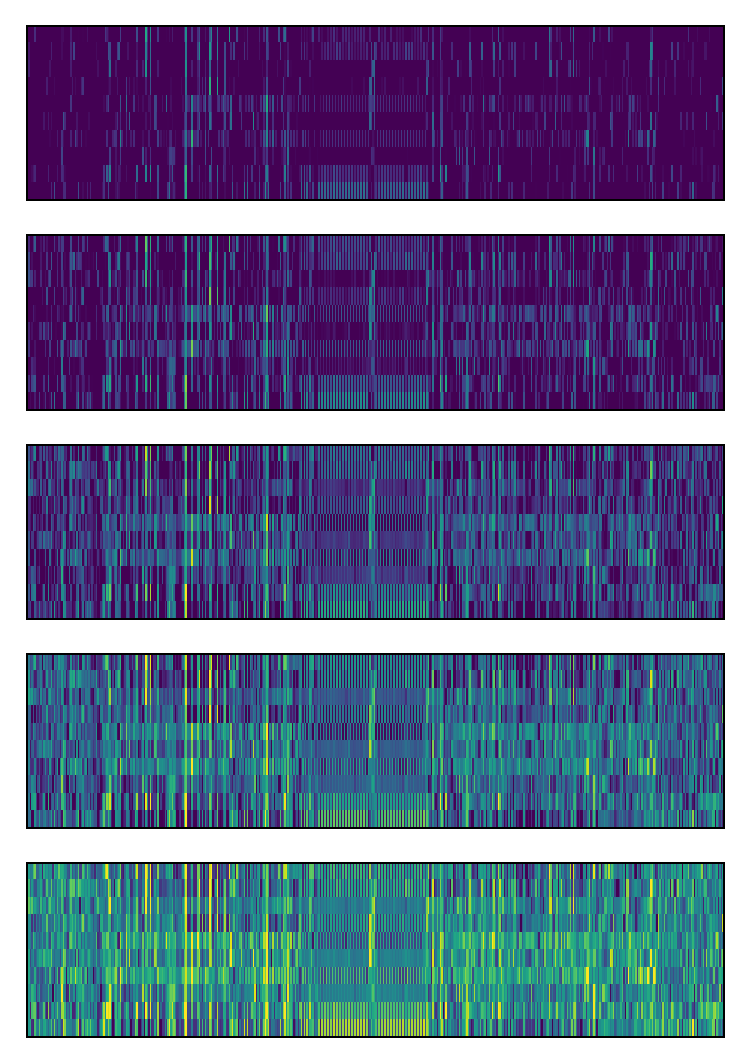

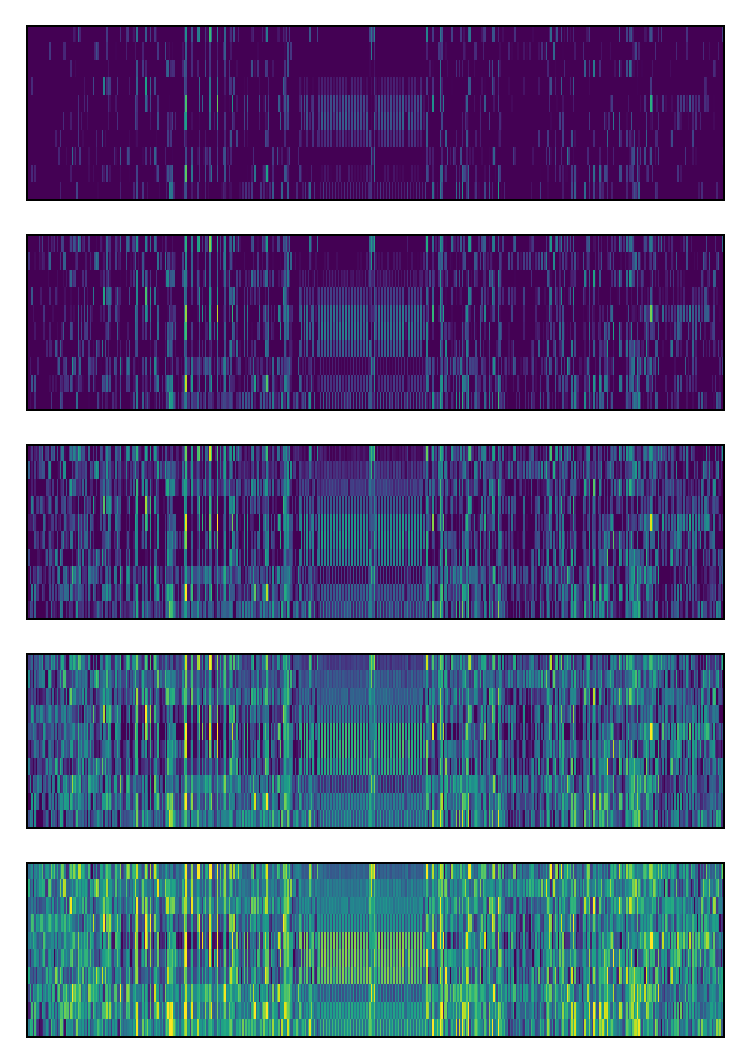

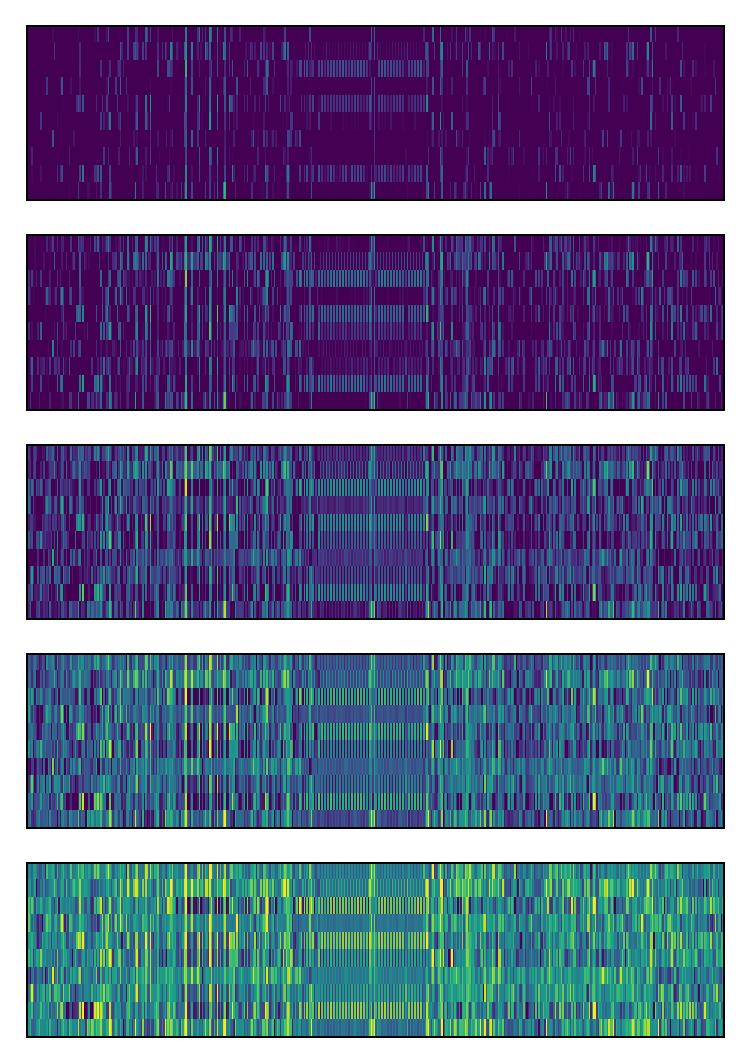

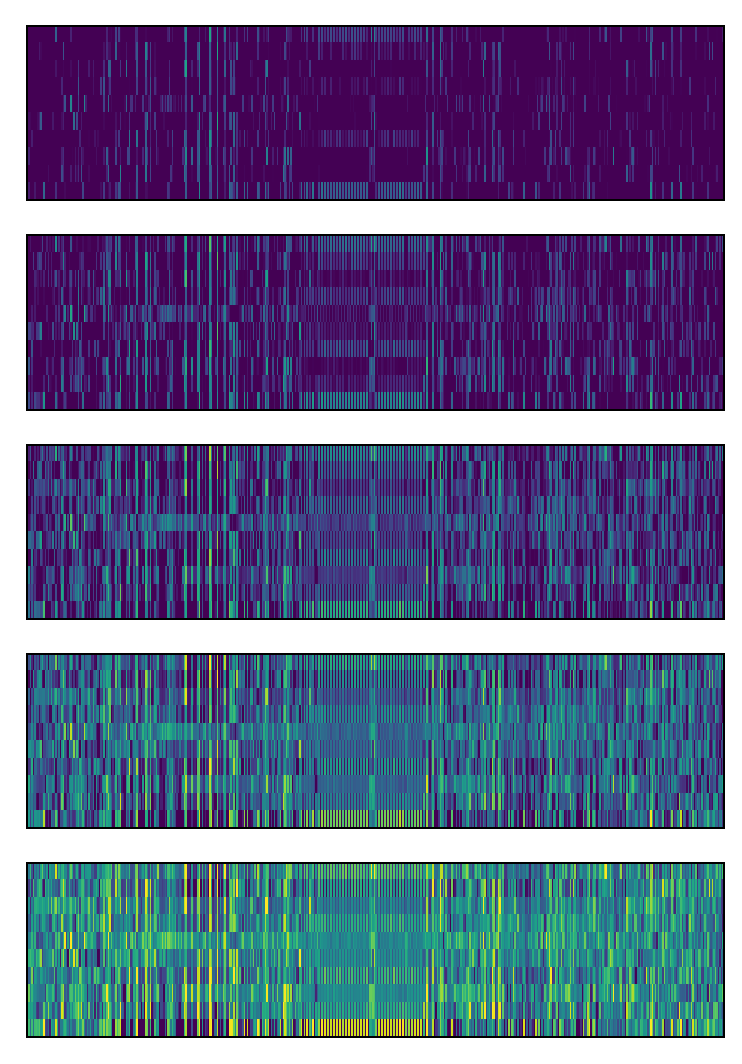

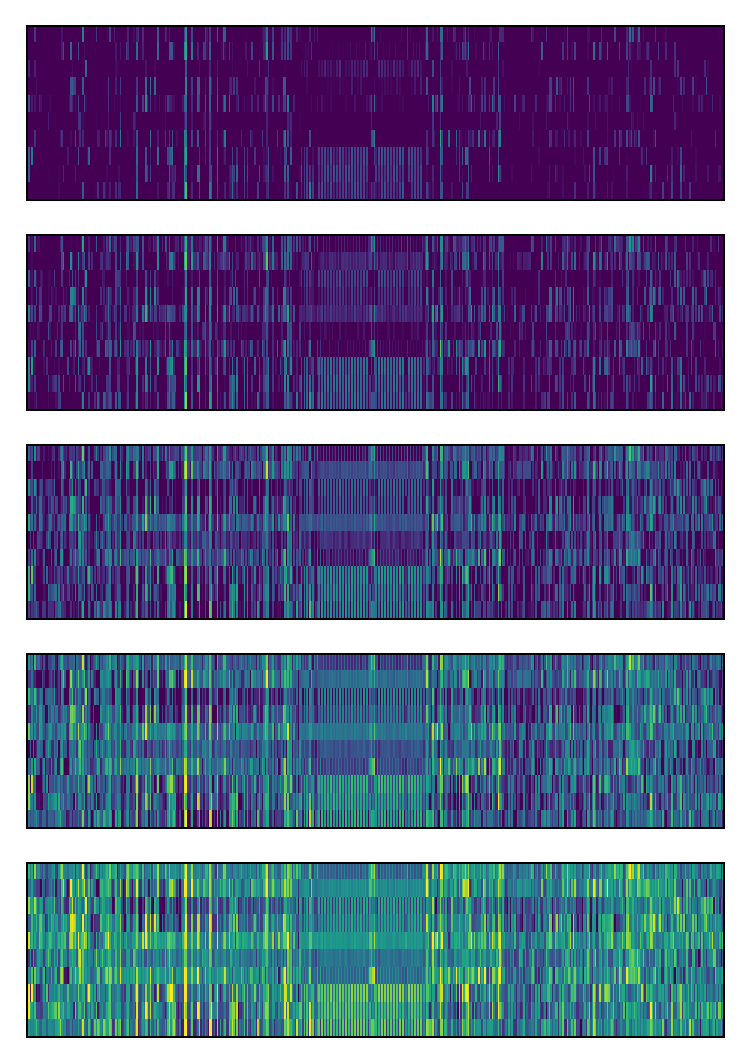

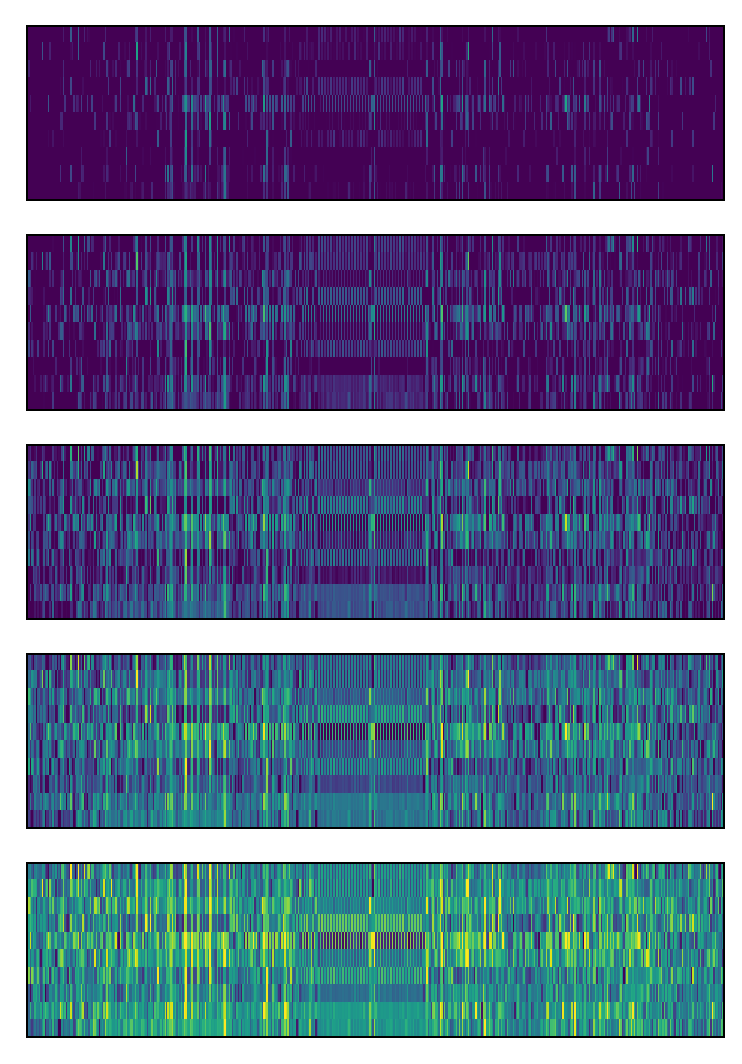

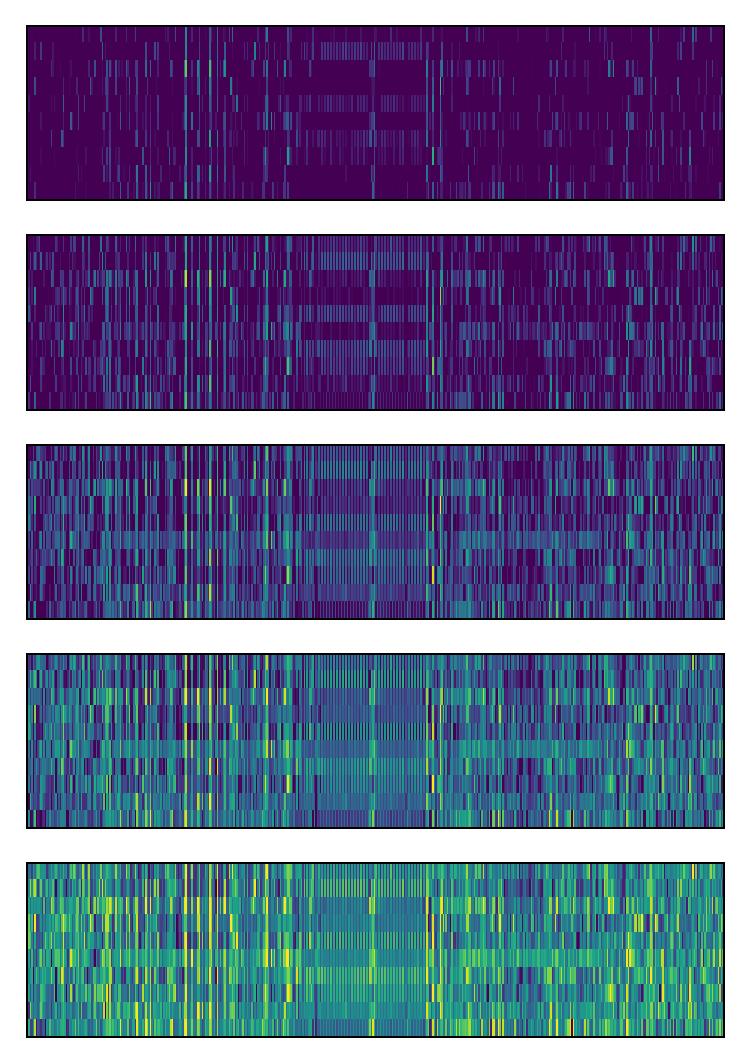

In [26]:
err_steps = list(range(-2, 3))

for k in most_reliable_voxel_means:
    vmax = np.quantile(most_reliable_voxel_means[k] + 2 * most_reliable_voxel_std_err[k], 0.99)
    fig, axes = make_figure(
        [SubplotArtist(width=5, height=0.125 * len(most_reliable_voxel_means[k])) for err_step in err_steps], dpi=180, 
        num_columns=1)
    for err_step, ax in zip(err_steps, axes):
        matshow(ax, np.maximum(most_reliable_voxel_means[k] + err_step * most_reliable_voxel_std_err[k], 0), vmin=0, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.show()


In [108]:
volume_dict = OrderedDict()
for k in most_reliable_voxel_indices:
    indicator_reliable = np.full(bootstrap_indicator_fmri_stat_sig[k].shape, 0)
    indicator_reliable[most_reliable_voxel_indices[k]] = 1
    volume_dict[k[-1]] = make_volume(indicator_reliable, k[-1], cmap='Blues', vmin=0, vmax=1)
                
cortex.webshow(volume_dict, open_browser=False)

Started server on port 56456


<WebApp(Thread-10, started 140470956971776)>

In [147]:
def label_count_cram(path):
    labels = dict()
    with open(path, 'rt') as f:
        for line in f:
            line = line.strip()
            if len(line) == 0:
                continue
            fields = line.split('\t')
            if len(fields) != 3:
                raise ValueError('Unexpected number of fields. Expected 3, got {}'.format(len(fields)))
            which, label, sentence = fields
            if which == 'tr':
                if label not in labels:
                    labels[label] = 1
                else:
                    labels[label] += 1
    return labels
    

def label_counts(file_name):
    import json
    counts = dict()
    with open(file_name) as f:
        for line in f:
            targets = json.loads(line)['targets']
            if len(targets) == 0:
                continue
            for d in targets:
                label = d['label']
                if isinstance(label, list):
                    for lbl in label:
                        if lbl not in counts:
                            counts[lbl] = 1
                        else:
                            counts[lbl] += 1
                else:
                    if label not in counts:
                        counts[label] = 1
                    else:
                        counts[label] += 1
    return counts
train_counts = label_count_cram('/share/volume0/drschwar/data_sets/what_you_can_cram/tree_depth.txt')
total = sum(train_counts[k] for k in train_counts)
for label in sorted(train_counts, key=lambda lbl: -train_counts[lbl]):
    print(label, train_counts[label], '{:.2%}'.format(train_counts[label] / total))

8 17886 17.89%
9 17763 17.76%
7 16506 16.51%
10 15383 15.38%
6 13510 13.51%
11 11923 11.92%
5 7029 7.03%


In [46]:
# bootstrap_result_dict_abs = np.load('bootstrap_similarities_no_pca_abs.npz')
# bootstrap_result_dict_abs = np.load('bootstrap_similarities_corr_abs.npz')
bootstrap_result_dict_abs = np.load('bootstrap_similarities_abs_cov_scaled_cosine.npz')
non_fmri_names_abs = bootstrap_result_dict_abs['feature_names_non_fmri']
indicator_good_feature_abs = bootstrap_result_dict_abs['indicator_stat_sig_non_fmri']
combined_mean_abs = bootstrap_result_dict_abs['mean_similarities']
combined_std_abs = bootstrap_result_dict_abs['std_similarities']

# bootstrap_result_dict_sum = np.load('bootstrap_similarities_no_pca_sign_norm.npz')
# bootstrap_result_dict_sum = np.load('bootstrap_similarities_corr_sign_norm.npz')
bootstrap_result_dict_sum = np.load('bootstrap_similarities_cov_scaled_cosine_sign_norm.npz')
non_fmri_names_sum = bootstrap_result_dict_sum['feature_names_non_fmri']
indicator_good_feature_sum = bootstrap_result_dict_sum['indicator_stat_sig_non_fmri']
combined_mean_sum = bootstrap_result_dict_sum['mean_similarities']
combined_std_sum = bootstrap_result_dict_sum['std_similarities']

# bootstrap_result_dict = np.load('bootstrap_similarities_no_pca.npz')
# bootstrap_result_dict = np.load('bootstrap_similarities_corr.npz')
bootstrap_result_dict = np.load('bootstrap_similarities_cov_scaled_cosine.npz')
non_fmri_names = bootstrap_result_dict['feature_names_non_fmri']
indicator_good_feature = bootstrap_result_dict['indicator_stat_sig_non_fmri']
combined_mean = bootstrap_result_dict['mean_similarities']
combined_std = bootstrap_result_dict['std_similarities']

In [86]:
at_least_1_percent = {
    'srl_conll': {
        'ARG1', #  203745 34.02%
        'ARG0', #  128704 21.49%
        'ARG2', #  70067 11.70%
        'ARGM-TMP', #  40342 6.74%
        'ARGM-MOD', #  22855 3.82%
        'ARGM-ADV', #  22293 3.72%
        'ARGM-DIS', #  21925 3.66%
        'ARGM-MNR', #  15189 2.54%
        'ARGM-LOC', #  14220 2.37%
        'ARGM-NEG', #  11788 1.97%
        'R-ARG0', #  7307 1.22%
    },
    'pos_conll': {
        'NN',  # 263627 12.73%
        'IN',  # 224557 10.85%
        'DT',  # 183396 8.86%
        'NNP',  # 163544 7.90%
        'JJ',  # 117516 5.68%
        'NNS',  # 109694 5.30%
        '.',  # 101336 4.89%
        ',',  # 91228 4.41%
        'PRP',  # 89053 4.30%
        'RB',  # 88694 4.28%
        'VB',  # 73552 3.55%
        'VBD',  # 67723 3.27%
        'CC',  # 61981 2.99%
        'VBZ',  # 49978 2.41%
        'VBP',  # 42821 2.07%
        'VBN',  # 41730 2.02%
        'CD',  # 40815 1.97%
        'VBG',  # 34296 1.66%
        'TO',  # 30754 1.49%
        'MD',  # 25497 1.23%
        'PRP$'  # 22983 1.11%
    },
    'const_conll': {
        'NP', #  670427 36.21%
        'VP', #  361720 19.54%
        'S', #  241106 13.02%
        'PP', #  195586 10.56%
        'TOP', #  110514 5.97%
        'SBAR', #  68767 3.71%
        'ADVP', #  58365 3.15%
        'ADJP', #  36350 1.96%
        'NML', #  27688 1.50%
        'WHNP', #  20894 1.13%
    },
    'ner_conll': {
        'ORG', #  24163 18.77%
        'PERSON', #  22035 17.12%
        'GPE', #  21938 17.04%
        'DATE', #  18791 14.60%
        'CARDINAL', #  10901 8.47%
        'NORP', #  9341 7.26%
        'MONEY', #  5217 4.05%
        'PERCENT', #  3802 2.95%
        'ORDINAL', #  2195 1.71%
        'LOC', #  2160 1.68%
        'TIME', #  1703 1.32%
    },
    'spr1_': {
        'existed_during', #  6566 15.15%
        'existed_after', #  5358 12.36%
        'existed_before', #  4978 11.49%
        'manipulated_by_another', #  4048 9.34%
        'awareness', #   3021 6.97%
        'instigation', #  2811 6.49%
        'predicate_changed_argument', #  2735 6.31%
        'volition', #   2728 6.29%
        'change_of_state', #  2705 6.24%
        'exists_as_physical', #  2663 6.14%
        'sentient', #  1856 4.28%
        'makes_physical_contact', #  1138 2.63%
        'location_of_event', #  621 1.43%
        'change_of_location', #  575 1.33%
        'created', #  549 1.27%
        'changes_possession', #  473 1.09%
    },
    'spr2_': {
        'existed_during', #  4789 13.30%
        'existed_after', #  4357 12.10%
        'was_used', #  4126 11.46%
        'existed_before', #  4071 11.31%
        'instigation', #  3130 8.69%
        'awareness', #  2656 7.38%
        'sentient', #  2595 7.21%
        'change_of_state_continuous', #  2244 6.23%
        'volition', #  2194 6.09%
        'was_for_benefit', #  1965 5.46%
        'change_of_state', #  1319 3.66%
        'partitive', #  1135 3.15%
        'change_of_location', #  960 2.67%
    },
    'sem_eval': {
        'Other', #  1222 17.84%
        'Entity-Destination(e1,e2)', #  727 10.61%
        'Cause-Effect(e2,e1)', #  560 8.17%
        'Member-Collection(e2,e1)', #  515 7.52%
        'Entity-Origin(e1,e2)', #  490 7.15%
        'Message-Topic(e1,e2)', #  412 6.01%
        'Component-Whole(e2,e1)', #  401 5.85%
        'Component-Whole(e1,e2)', #  400 5.84%
        'Instrument-Agency(e2,e1)', #  353 5.15%
        'Product-Producer(e2,e1)', #  347 5.06%
        'Content-Container(e1,e2)', #  334 4.88%
        'Cause-Effect(e1,e2)',  # 296 4.32%
        'Product-Producer(e1,e2)', #  264 3.85%
        'Content-Container(e2,e1)', #  136 1.99%
        'Entity-Origin(e2,e1)', # 123 1.80%
        'Message-Topic(e2,e1)', #  114 1.66%
        'Instrument-Agency(e1,e2)', # 88 1.28%
    },
    'dep_ewt': {
        'punct', #  23505 11.53%
        'case', #  17382 8.52%
        'nsubj', #  16215 7.95%
        'det', #  15705 7.70%
        'root', #  12522 6.14%
        'advmod', #  10930 5.36%
        'obj', #  10159 4.98%
        'obl', #  9124 4.47%
        'amod', #  9041 4.43%
        'compound', #  8172 4.01%
        'conj', #  7522 3.69%
        'mark', #  7457 3.66%
        'nmod', #  6891 3.38%
        'cc', #  6754 3.31%
        'aux', #  6505 3.19%
        'cop', #  4455 2.18%
        'advcl', #  3833 1.88%
        'nmod:poss', #  3659 1.79%
        'xcomp', #  3012 1.48%
        'nummod', #  2521 1.24%
        'ccomp', #  2383 1.17%
    }
}




In [94]:
from subplot_artist import SubplotArtistGrid
erp_set = {'n400', 'p600', 'pnp', 'epnp', 'elan', 'lan'}
eye_tracking_set = {'first_fixation', 'first_pass', 'right_bounded', 
     'go_past', 'word_first_fixation_duration', 
     'word_fixation_count', 'word_gaze_duration', 'word_go_past_time',
     'word_total_reading_time', 'dun_fst_pst', 'dun_go_pst', 'dun_rt_bnd'}
reading_time_set = {'reading_time'}

non_nlp_set = set(erp_set)
non_nlp_set.update(eye_tracking_set)
non_nlp_set.update(reading_time_set)

indicator_nlp = np.array(list(n not in non_nlp_set for n in non_fmri_names))
indicator_good_nlp = np.logical_and(indicator_good_feature, indicator_nlp)

# n_to_i = dict((n, i) for i, n in enumerate(n for b, n in zip(indicator_good_nlp, non_fmri_names) if b))
# indicator_span_1 = np.full(np.sum(indicator_good_nlp), False)
# indicator_span_0_with_span_1 = np.full(np.sum(indicator_good_nlp), False)
# for n in n_to_i:
#     if n.endswith('span1'):
#         indicator_span_1[n_to_i[n]] = True
#         n_span0 = n[:-len('span1')] + 'span0'
#         indicator_span_0_with_span_1[n_to_i[n]] = True
        
indicator_good_nlp_col = indicator_nlp[indicator_good_feature]

nlp_abs = combined_mean_abs[3:][indicator_good_feature]
nlp_sum = combined_mean_sum[3:][indicator_good_feature]
nlp_x = combined_mean[3:][indicator_good_feature]
# nlp_flip = combined_mean[3:][indicator_good_nlp][:, indicator_good_nlp_col]

# indicator_opp = np.logical_and(np.expand_dims(indicator_span_1, 1), np.expand_dims(indicator_span_0_with_span_1, 0))
# indicator_opp = np.logical_or(
#     indicator_opp, 
#     np.logical_and(np.expand_dims(indicator_span_0_with_span_1, 1), np.expand_dims(indicator_span_1, 0)))
# nlp_flip = np.where(indicator_span_1, -nlp_flip, nlp_flip)
# nlp_flip = nlp_flip[100:150, 100:150]



def views(prefix, row_excl_suffix, col_excl_suffix, use_at_least=True):
    indicator_view_row = np.full(np.sum(indicator_good_feature), False)
    indicator_view_col = np.full(np.sum(indicator_good_feature), False)
    for i, n in enumerate(n for b, n in zip(indicator_good_feature, non_fmri_names) if b):
        row_suffix = row_excl_suffix
        col_suffix = col_excl_suffix
        is_match = False
        if prefix is None:
            is_match = True
        else: 
            if np.ndim(prefix) == 0:
                prefix = [prefix]
            for p in prefix:
                if p == 'erp':
                    is_match = n in erp_set
                elif p == 'eye':
                    is_match = n in eye_tracking_set
                elif p == 'read':
                    is_match = n in reading_time_set
                else:
                    is_match = n.startswith(p)
                if is_match:
                    break
        if not is_match:
            continue
        
        if n.startswith('spr1_') or n.startswith('spr2_'):
            at_least_key = n[:len('spr1_')]
            k = n[len('spr1_'):].split('.')[0]
        else:
            at_least_key = None
            k = None
            parts = n.split('.')
            if len(parts) > 1:
                at_least_key = parts[0]
                k = parts[1]
        current_at_least = None
        if (use_at_least is True or at_least_key in use_at_least) and at_least_key in at_least_1_percent:
            current_at_least = at_least_1_percent[at_least_key]
            if k not in current_at_least:
                continue
        if row_suffix is not None and callable(row_suffix):
            row_suffix = row_suffix(at_least_key)
        if col_suffix is not None and callable(col_suffix):
            col_suffix = col_suffix(at_least_key)
        if row_suffix is None or not n.endswith(row_suffix):
            indicator_view_row[i] = True
        if col_suffix is None or not n.endswith(col_suffix):
            indicator_view_col[i] = True
    return indicator_view_row, indicator_view_col

# grid = SubplotArtistGrid(num_columns=4, num_rows=3)
# colorbar_artist = ColorbarArtist(width=0.2, height=15)
# locations = dict()
# grid[0:3, 3] = colorbar_artist
# for column, mat in enumerate([nlp_x, nlp_sum, nlp_abs]):
#     for row in range(3):
#         if row == 0:
#             indicator_view_row, indicator_view_col = views(['top_const', 'dep_ewt', 'pos_conll', 'const_conll', 'spr1_', 'spr2_'], 'span1', 'span1')
#             if column == 0:
#                 cnt = 0
#                 for i, n in enumerate(n for b, n in zip(indicator_good_nlp, non_fmri_names) if b):
#                     if indicator_view_row[i]:
#                         print(cnt, n)
#                         cnt += 1
#         elif row == 1:
#             indicator_view_row, indicator_view_col = views(['top_const', 'dep_ewt', 'pos_conll', 'const_conll', 'spr1_', 'spr2_'], 'span0', 'span0')
#         else:
#             indicator_view_row, indicator_view_col = views(['top_const', 'dep_ewt', 'pos_conll', 'const_conll', 'spr1_', 'spr2_'], 'span1', 'span0')
#         mat_ = mat[indicator_view_row][:, indicator_view_col]
#         ca = colorbar_artist if row == 0 and column == 0 else None
#         artist = SubplotArtist(
#             width=5, height=5, 
#             render_fn=(lambda m: lambda ax: matshow(ax, m, cmap='coolwarm', vmin=-1, vmax=1))(mat_), colorbar_artist=ca)
#         grid[row, column] = artist
#         locations[artist] = row, column

# fig, axes = grid.make_figure(dpi=180)
# for artist in axes:
#     artist.render(axes[artist])
#     if artist == colorbar_artist:
#         axes[artist].tick_params(labelsize=14)
#         continue
#     for i in range(0, 91, 5):
#         axes[artist].axhline(i - 0.5, color='black')
#         axes[artist].axvline(i - 0.5, color='black')
#     if locations[artist][1] == 0:
#         if locations[artist][0] == 0:
#             axes[artist].set_ylabel('span0 vs. span0', fontsize=16)
#         elif locations[artist][0] == 1:
#             axes[artist].set_ylabel('span1 vs. span1', fontsize=16)
#         else:
#             axes[artist].set_ylabel('span0 vs. span1', fontsize=16)
# #     if locations[artist][0] == 0 and locations[artist][1] == 1:
# #         axes[artist].set_title('Depend. / proto-role sim.', fontsize=20)
#     axes[artist].set_xticks([])
#     axes[artist].set_yticks([])
# fig.figure.suptitle('Top-const, PoS, Const, Depend., and Proto-Role Similarities', fontsize=20, y=1.01)
# # fig.show(is_tight_layout=True)
# fig.show(output_figure_path='top_pos_const_dep_proto_similarities.png', is_tight_layout=True)

grid = SubplotArtistGrid(num_columns=2, num_rows=2)
colorbar_artist = ColorbarArtist(width=0.2, height=16)
grid[1, 1] = colorbar_artist
locations = dict()
counts = dict()

fmri_ca = ColorbarArtist(width=0.2, height=4)
grid[0, 1] = fmri_ca
for row, mat in enumerate([nlp_x]): # , nlp_sum, nlp_abs]):
    indicator_view_row, indicator_view_col = views(
        None, 
        None,  # lambda p: None if p in {'coref_conll', 'sem_eval'} else 'span1' if p == 'dep_ewt' else 'span0', 
        None)  # lambda p: None if p in {'coref_conll', 'sem_eval'} else 'span1' if p == 'dep_ewt' else 'span0')
    if row == 0:
        cnt = 0
        for i, n in enumerate(n for b, n in zip(indicator_good_feature, non_fmri_names) if b):
            if indicator_view_row[i]:
                print(cnt, n)
                cnt += 1
    mat_ = mat[indicator_view_row][:, indicator_view_col]
    
    fmri_dict = fmri_summary('cos')
    fmri = list()
    for subject in fmri_dict:
        for roi in fmri_dict[subject]:
            fmri.append(fmri_dict[subject][roi])
    fmri = np.concatenate(fmri)
    fmri = fmri[:, indicator_view_col]
    fmri_a = SubplotArtist(
        width=15, height=4, colorbar_artist=fmri_ca,
        render_fn=lambda ax: matshow(ax, fmri, cmap='coolwarm', vmin=-.06, vmax=.06))
    grid[0, 0] = fmri_a
    locations[fmri_a] = 0, 0
    counts[fmri_a] = len(fmri)

    ca = colorbar_artist if row == 0 else None
    artist = SubplotArtist(
        width=15, height=16, 
        render_fn=(lambda m: lambda ax: matshow(ax, m, cmap='coolwarm', vmin=-1, vmax=1))(mat_), colorbar_artist=ca)
    grid[1, 0] = artist
    locations[artist] = 1, 0
    counts[artist] = len(mat_)


fig, axes = grid.make_figure(dpi=180)
for artist in axes:
    artist.render(axes[artist])
    if artist == colorbar_artist or artist == fmri_ca:
        axes[artist].tick_params(labelsize=14)
        continue
#     if locations[artist][1] == 0:
#         if locations[artist][0] == 0:
#             axes[artist].set_ylabel('cos', fontsize=16)
#         elif locations[artist][0] == 1:
#             axes[artist].set_ylabel('sign-normalized', fontsize=16)
#         else:
#             axes[artist].set_ylabel('abs', fontsize=16)
#     if locations[artist][1] == 0:
#         axes[artist].set_ylabel('mixed spans vs. mixed spans', fontsize=16)
    if locations[artist][0] == 0 and locations[artist][1] == 0:
        axes[artist].set_title('Task Similarities', y=1.1, fontsize=20)
    axes[artist].set_xticks(range(0, 232, 20))
    axes[artist].set_xticklabels(np.arange(0, 232, 20) + 1)
    if artist == fmri_a:
        axes[artist].set_yticks(np.arange(3, 70, 8) + 0.5)
        axes[artist].set_yticklabels(['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'])
        axes[artist].tick_params(axis='y', length=0)
    else:
        axes[artist].set_yticks(range(0, counts[artist], 20))
        axes[artist].set_yticklabels(np.arange(0, counts[artist], 20) + 1)
    axes[artist].tick_params(labelsize=14)
    
    grid_line_width = 0.5
    grid_color_a = 'black'
    grid_color_b = 'gray'
    
    if artist == fmri_a:
        for i in range(0, counts[artist] + 1, 16):
            axes[artist].axhline(i - 0.5, color=grid_color_a, linewidth=grid_line_width)
        for i in range(8, counts[artist] + 1, 16):
            axes[artist].axhline(i - 0.5, color=grid_color_b, linewidth=grid_line_width)
    else:
        for i in range(0, counts[artist] + 1, 10):
            axes[artist].axhline(i - 0.5, color=grid_color_a, linewidth=grid_line_width)
        for i in range(5, counts[artist] + 1, 10):
            axes[artist].axhline(i - 0.5, color=grid_color_b, linewidth=grid_line_width)
    for i in range(0, 232, 10):    
        axes[artist].axvline(i - 0.5, color=grid_color_a, linewidth=grid_line_width)
    for i in range(5, 232, 10):    
        axes[artist].axvline(i - 0.5, color=grid_color_b, linewidth=grid_line_width)    
# fig.show(is_tight_layout=True)
fig.show(output_figure_path='full_similarities.png', is_tight_layout=True)


0 elan
1 lan
2 n400
3 epnp
4 p600
5 pnp
6 first_fixation
7 first_pass
8 right_bounded
9 go_past
10 reading_time
11 word_first_fixation_duration
12 word_fixation_count
13 word_gaze_duration
14 word_go_past_time
15 word_total_reading_time
16 dun_fst_pst
17 dun_go_pst
18 dun_rt_bnd
19 sentiment
20 bshift
21 obj_num
22 sent_len.0
23 sent_len.1
24 sent_len.2
25 sent_len.3
26 sent_len.4
27 sent_len.5
28 subj_num
29 top_const.ADVP_NP_VP_.
30 top_const.CC_ADVP_NP_VP_.
31 top_const.CC_NP_VP_.
32 top_const.IN_NP_VP_.
33 top_const.NP_ADVP_VP_.
34 top_const.NP_NP_VP_.
35 top_const.NP_PP_.
36 top_const.NP_VP_.
37 top_const.OTHER
38 top_const.PP_NP_VP_.
39 top_const.RB_NP_VP_.
40 top_const.SBAR_NP_VP_.
41 top_const.SBAR_VP_.
42 top_const.S_CC_S_.
43 top_const.S_NP_VP_.
44 top_const.S_VP_.
45 top_const.VBD_NP_VP_.
46 top_const.VP_.
47 top_const.WHADVP_SQ_.
48 top_const.WHNP_SQ_.
49 tree_depth.10
50 tree_depth.11
51 tree_depth.5
52 tree_depth.6
53 tree_depth.7
54 tree_depth.8
55 tree_depth.9
56 tense


In [140]:
from subplot_artist import SubplotArtistGrid
erp_set = {'n400', 'p600', 'pnp', 'epnp', 'elan', 'lan'}
eye_tracking_set = {'first_fixation', 'first_pass', 'right_bounded', 
     'go_past', 'word_first_fixation_duration', 
     'word_fixation_count', 'word_gaze_duration', 'word_go_past_time',
     'word_total_reading_time', 'dun_fst_pst', 'dun_go_pst', 'dun_rt_bnd'}
reading_time_set = {'reading_time'}

non_nlp_set = set(erp_set)
non_nlp_set.update(eye_tracking_set)
non_nlp_set.update(reading_time_set)

indicator_nlp = np.array(list(n not in non_nlp_set for n in non_fmri_names))
indicator_good_nlp = np.logical_and(indicator_good_feature, indicator_nlp)

# n_to_i = dict((n, i) for i, n in enumerate(n for b, n in zip(indicator_good_nlp, non_fmri_names) if b))
# indicator_span_1 = np.full(np.sum(indicator_good_nlp), False)
# indicator_span_0_with_span_1 = np.full(np.sum(indicator_good_nlp), False)
# for n in n_to_i:
#     if n.endswith('span1'):
#         indicator_span_1[n_to_i[n]] = True
#         n_span0 = n[:-len('span1')] + 'span0'
#         indicator_span_0_with_span_1[n_to_i[n]] = True
        
indicator_good_nlp_col = indicator_nlp[indicator_good_feature]

nlp_abs = combined_mean_abs[3:][indicator_good_feature]
nlp_sum = combined_mean_sum[3:][indicator_good_feature]
nlp_x = combined_mean[3:][indicator_good_feature]
# nlp_flip = combined_mean[3:][indicator_good_nlp][:, indicator_good_nlp_col]

# indicator_opp = np.logical_and(np.expand_dims(indicator_span_1, 1), np.expand_dims(indicator_span_0_with_span_1, 0))
# indicator_opp = np.logical_or(
#     indicator_opp, 
#     np.logical_and(np.expand_dims(indicator_span_0_with_span_1, 1), np.expand_dims(indicator_span_1, 0)))
# nlp_flip = np.where(indicator_span_1, -nlp_flip, nlp_flip)
# nlp_flip = nlp_flip[100:150, 100:150]



def views(prefix, row_excl_suffix, col_excl_suffix, use_at_least=True):
    indicator_view_row = np.full(np.sum(indicator_good_feature), False)
    indicator_view_col = np.full(np.sum(indicator_good_feature), False)
    for i, n in enumerate(n for b, n in zip(indicator_good_feature, non_fmri_names) if b):
        row_suffix = row_excl_suffix
        col_suffix = col_excl_suffix
        is_match = False
        if prefix is None:
            is_match = True
        else: 
            if np.ndim(prefix) == 0:
                prefix = [prefix]
            for p in prefix:
                if p == 'erp':
                    is_match = n in erp_set
                elif p == 'eye':
                    is_match = n in eye_tracking_set
                elif p == 'read':
                    is_match = n in reading_time_set
                else:
                    is_match = n.startswith(p)
                if is_match:
                    break
        if not is_match:
            continue
        
        if n.startswith('spr1_') or n.startswith('spr2_'):
            at_least_key = n[:len('spr1_')]
            k = n[len('spr1_'):].split('.')[0]
        else:
            at_least_key = None
            k = None
            parts = n.split('.')
            if len(parts) > 1:
                at_least_key = parts[0]
                k = parts[1]
        current_at_least = None
        if (use_at_least is True or at_least_key in use_at_least) and at_least_key in at_least_1_percent:
            current_at_least = at_least_1_percent[at_least_key]
            if k not in current_at_least:
                continue
        if row_suffix is not None and callable(row_suffix):
            row_suffix = row_suffix(at_least_key)
        if col_suffix is not None and callable(col_suffix):
            col_suffix = col_suffix(at_least_key)
        if row_suffix is None or not n.endswith(row_suffix):
            indicator_view_row[i] = True
        if col_suffix is None or not n.endswith(col_suffix):
            indicator_view_col[i] = True
    return indicator_view_row, indicator_view_col

# grid = SubplotArtistGrid(num_columns=4, num_rows=3)
# colorbar_artist = ColorbarArtist(width=0.2, height=15)
# locations = dict()
# grid[0:3, 3] = colorbar_artist
# for column, mat in enumerate([nlp_x, nlp_sum, nlp_abs]):
#     for row in range(3):
#         if row == 0:
#             indicator_view_row, indicator_view_col = views(['top_const', 'dep_ewt', 'pos_conll', 'const_conll', 'spr1_', 'spr2_'], 'span1', 'span1')
#             if column == 0:
#                 cnt = 0
#                 for i, n in enumerate(n for b, n in zip(indicator_good_nlp, non_fmri_names) if b):
#                     if indicator_view_row[i]:
#                         print(cnt, n)
#                         cnt += 1
#         elif row == 1:
#             indicator_view_row, indicator_view_col = views(['top_const', 'dep_ewt', 'pos_conll', 'const_conll', 'spr1_', 'spr2_'], 'span0', 'span0')
#         else:
#             indicator_view_row, indicator_view_col = views(['top_const', 'dep_ewt', 'pos_conll', 'const_conll', 'spr1_', 'spr2_'], 'span1', 'span0')
#         mat_ = mat[indicator_view_row][:, indicator_view_col]
#         ca = colorbar_artist if row == 0 and column == 0 else None
#         artist = SubplotArtist(
#             width=5, height=5, 
#             render_fn=(lambda m: lambda ax: matshow(ax, m, cmap='coolwarm', vmin=-1, vmax=1))(mat_), colorbar_artist=ca)
#         grid[row, column] = artist
#         locations[artist] = row, column

# fig, axes = grid.make_figure(dpi=180)
# for artist in axes:
#     artist.render(axes[artist])
#     if artist == colorbar_artist:
#         axes[artist].tick_params(labelsize=14)
#         continue
#     for i in range(0, 91, 5):
#         axes[artist].axhline(i - 0.5, color='black')
#         axes[artist].axvline(i - 0.5, color='black')
#     if locations[artist][1] == 0:
#         if locations[artist][0] == 0:
#             axes[artist].set_ylabel('span0 vs. span0', fontsize=16)
#         elif locations[artist][0] == 1:
#             axes[artist].set_ylabel('span1 vs. span1', fontsize=16)
#         else:
#             axes[artist].set_ylabel('span0 vs. span1', fontsize=16)
# #     if locations[artist][0] == 0 and locations[artist][1] == 1:
# #         axes[artist].set_title('Depend. / proto-role sim.', fontsize=20)
#     axes[artist].set_xticks([])
#     axes[artist].set_yticks([])
# fig.figure.suptitle('Top-const, PoS, Const, Depend., and Proto-Role Similarities', fontsize=20, y=1.01)
# # fig.show(is_tight_layout=True)
# fig.show(output_figure_path='top_pos_const_dep_proto_similarities.png', is_tight_layout=True)

grid = SubplotArtistGrid(num_columns=3, num_rows=1)
colorbar_artist = ColorbarArtist(width=0.2, height=16)
grid[0, 2] = colorbar_artist
locations = dict()
counts = dict()

for row, mat in enumerate([nlp_x, nlp_x]): # , nlp_sum, nlp_abs]):
    indicator_view_row, indicator_view_col = views(
        'srl_conll', 
        'span1' if row == 0 else 'span0',  # lambda p: None if p in {'coref_conll', 'sem_eval'} else 'span1' if p == 'dep_ewt' else 'span0', 
        'span1' if row == 0 else 'span0', use_at_least=[])  # lambda p: None if p in {'coref_conll', 'sem_eval'} else 'span1' if p == 'dep_ewt' else 'span0')
    if row == 0:
        cnt = 0
        for i, n in enumerate(n for b, n in zip(indicator_good_feature, non_fmri_names) if b):
            if indicator_view_row[i]:
                print(cnt, n)
                cnt += 1
    mat_ = mat[indicator_view_row][:, indicator_view_col]
    
    ca = colorbar_artist if row == 0 else None
    artist = SubplotArtist(
        width=15, height=16, 
        render_fn=(lambda m: lambda ax: matshow(ax, m, cmap='coolwarm', vmin=-1, vmax=1))(mat_), colorbar_artist=ca)
    grid[0, row] = artist
    locations[artist] = 0, row
    counts[artist] = len(mat_)

fig, axes = grid.make_figure(dpi=180)
for artist in axes:
    artist.render(axes[artist])
    if artist == colorbar_artist:
        axes[artist].tick_params(labelsize=14)
        continue
    if locations[artist][1] == 0:
        axes[artist].set_xlabel('Span 0', fontsize=16)
    elif locations[artist][1] == 1:
        axes[artist].set_xlabel('Span 1', fontsize=16)
#     if locations[artist][1] == 0:
#         if locations[artist][0] == 0:
#             axes[artist].set_ylabel('cos', fontsize=16)
#         elif locations[artist][0] == 1:
#             axes[artist].set_ylabel('sign-normalized', fontsize=16)
#         else:
#             axes[artist].set_ylabel('abs', fontsize=16)
#     if locations[artist][1] == 0:
#         axes[artist].set_ylabel('mixed spans vs. mixed spans', fontsize=16)
#     if locations[artist][0] == 0 and locations[artist][1] == 0:
#         axes[artist].set_title('Semantic Role Unfiltered Task Similarities', y=1.1, fontsize=20)

    # SemEval relations if use_at_least=True
    # grid_lines = np.array([0, 2, 6, 10, 12, 14, 18, 20, 22, 24])
    # SemEval relations if use_at_least=[]
    # grid_lines = np.array([0, 4, 8, 12, 16, 20, 24, 28, 32, 34])
    
    grid_lines = np.arange(0, counts[artist] + 1, 5)
    ticks = np.array(list(g for i, g in enumerate(grid_lines) if i % 2 == 0))
    
    axes[artist].set_xticks(ticks)
    axes[artist].set_xticklabels(ticks + 1)
    axes[artist].set_yticks(ticks)
    axes[artist].set_yticklabels(ticks + 1)
    axes[artist].tick_params(labelsize=14)
    
    for i, g in enumerate(grid_lines):
        grid_color = 'black' if i % 2 == 0 else 'gray'
        # grid_color='black'
        line_width = 1
        axes[artist].axhline(g - 0.5, color=grid_color, linewidth=line_width)
        axes[artist].axvline(g - 0.5, color=grid_color, linewidth=line_width)

fig.figure.suptitle('Unfiltered Semantic Role Task Similarities', fontsize=20, y=1.05)
# fig.show(is_tight_layout=True)
fig.show(output_figure_path='srl_unfiltered_similarities.png', is_tight_layout=True)


0 srl_conll.ARG0.span0
1 srl_conll.ARG1.span0
2 srl_conll.ARG2.span0
3 srl_conll.ARG3.span0
4 srl_conll.ARG4.span0
5 srl_conll.ARG5.span0
6 srl_conll.ARGA.span0
7 srl_conll.ARGM-ADJ.span0
8 srl_conll.ARGM-ADV.span0
9 srl_conll.ARGM-CAU.span0
10 srl_conll.ARGM-COM.span0
11 srl_conll.ARGM-DIR.span0
12 srl_conll.ARGM-DIS.span0
13 srl_conll.ARGM-DSP.span0
14 srl_conll.ARGM-EXT.span0
15 srl_conll.ARGM-GOL.span0
16 srl_conll.ARGM-LOC.span0
17 srl_conll.ARGM-LVB.span0
18 srl_conll.ARGM-MNR.span0
19 srl_conll.ARGM-MOD.span0
20 srl_conll.ARGM-NEG.span0
21 srl_conll.ARGM-PNC.span0
22 srl_conll.ARGM-PRD.span0
23 srl_conll.ARGM-PRP.span0
24 srl_conll.ARGM-PRR.span0
25 srl_conll.ARGM-PRX.span0
26 srl_conll.ARGM-REC.span0
27 srl_conll.ARGM-TMP.span0
28 srl_conll.C-ARG0.span0
29 srl_conll.C-ARG1.span0
30 srl_conll.C-ARG2.span0
31 srl_conll.C-ARG3.span0
32 srl_conll.C-ARG4.span0
33 srl_conll.C-ARGM-ADJ.span0
34 srl_conll.C-ARGM-ADV.span0
35 srl_conll.C-ARGM-CAU.span0
36 srl_conll.C-ARGM-COM.span0
37 s

In [96]:
from subplot_artist import SubplotArtistGrid

def roi_masks():
    from bert_brain import get_fedorenko_roi_masks
    fedorenko_roi_masks = get_fedorenko_roi_masks()
    result = dict()
    for roi in fedorenko_roi_masks:
        result[roi] = dict()
        for subject in fedorenko_roi_masks[roi]:
            subj_mask = get_mask_for_subject(subject)
            indicator_roi = fedorenko_roi_masks[roi][subject][subj_mask]
            result[roi][subject] = indicator_roi
    return result

def indicator_at_least():
    indicator_result = np.full(np.sum(indicator_good_feature), False)
    names = list()
    for i, n in enumerate(n for b, n in zip(indicator_good_feature, non_fmri_names) if b):
        current_at_least = None
        if n.startswith('spr1_') or n.startswith('spr2_'):
            prefix = n[:len('spr1_')]
            k = n[len('spr1_'):].split('.')[0]
        else:
            prefix = None
            k = None
            parts = n.split('.')
            if len(parts) > 1:
                prefix = parts[0]
                k = parts[1]
        if prefix in at_least_1_percent:
            current_at_least = at_least_1_percent[prefix]
        indicator_result[i] = current_at_least is None or k in current_at_least
        if indicator_result[i]:
            names.append(n)
    return indicator_result, names


def indicator_knn(x, use_abs=True, num_neighbors=20):
    # find the 20 nearest neighbors
    indices_sort = np.argsort(-np.abs(x) if use_abs else -x, axis=1)
    indices_sort = indices_sort[:, :num_neighbors]
    indices_sort_b = np.tile(
        np.expand_dims(np.arange(indices_sort.shape[0]), 1), (1, indices_sort.shape[1]))
    indices_sort = np.reshape(indices_sort, -1)
    indices_sort_b = np.reshape(indices_sort_b, -1)
    result = np.full_like(x, False)
    result[(indices_sort_b, indices_sort)] = True
    return result


def fmri_summary(which, show_full=False, show_summary=False):
    
    indicator_keep, good_names = indicator_at_least()
    
    if which == 'cos':
        brd = bootstrap_result_dict
        vmax = 0.06
        vmin = -vmax
        cmap = 'coolwarm'
    elif which == 'sign':
        brd = bootstrap_result_dict_sum
        vmax = 0.1
        vmin = -vmax
        cmap = 'coolwarm'
    elif which == 'abs':
        brd = bootstrap_result_dict_abs
        vmax = 0.3
        vmin = 0
        cmap = 'viridis'
    else:
        raise ValueError('Unknown value for which: {}'.format(which))

    roi_to_indicators = roi_masks()
    fmri_sim_by_roi = dict()
    fmri_sim_by_roi_std = dict()
    sorted_corr = dict()
    for roi in roi_to_indicators:
        fmri_sim_by_roi[roi] = dict()
        fmri_sim_by_roi_std[roi] = dict()
        sorted_corr[roi] = dict()
        for subject in roi_to_indicators[roi]:
            indicator_stat_sig = brd['stat_sig_hp_fmri_{}'.format(subject)]
            indicator_roi = roi_to_indicators[roi][subject]
            fmri_sim = brd['fmri_mean_similarities_hp_fmri_{}'.format(subject)]
            fmri_sim_std = brd['fmri_std_similarities_hp_fmri_{}'.format(subject)]
            assert(fmri_sim.shape[0] == np.sum(indicator_stat_sig))
            indicator_roi = indicator_roi[indicator_stat_sig]
            corr = np.squeeze(full_variation_results['hp_fmri_{}'.format(subject)].model_mean, axis=0)[indicator_stat_sig]
            corr = corr[indicator_roi]
            fmri_sim = fmri_sim[indicator_roi]
            fmri_sim_std[indicator_roi]
            indices_sort = np.argsort(-corr)
            fmri_sim = fmri_sim[indices_sort]
            fmri_sim_std = fmri_sim_std[indices_sort]
            sorted_corr[roi][subject] = corr[indices_sort]
            fmri_sim_by_roi[roi][subject] = fmri_sim
            fmri_sim_by_roi_std[roi][subject] = fmri_sim_std

    weighted_means = dict()

    for roi in fmri_sim_by_roi:
        outer_grid = SubplotArtistGrid(num_rows=1, num_columns=2, wspace=0.02)
        grid = SubplotArtistGrid(num_rows=3, num_columns=3, wspace=0.15, hspace=0.1)
        outer_grid[0, 0] = grid
        artist_to_subject = dict()
        main_artists = set()

        colorbar_artist = ColorbarArtist(width=0.2, height=16)
        outer_grid[0, 1] = colorbar_artist

        weighted_means[roi] = dict()

        for i, subject in enumerate(sorted(fmri_sim_by_roi[roi])):
            sub_grid = SubplotArtistGrid(num_rows=3, num_columns=1, hspace=0.05)
            row, col = divmod(i, 3)
            grid[row, col] = sub_grid

            roi_sim = fmri_sim_by_roi[roi][subject][:, indicator_keep]
            roi_sim_std = fmri_sim_by_roi_std[roi][subject][:, indicator_keep]
            roi_sim = np.where(2 * roi_sim_std >= np.abs(roi_sim), np.nan, roi_sim)
            ca = colorbar_artist if row == 0 and col == 0 else None

            roi_sim_near = np.where(indicator_knn(roi_sim), roi_sim, np.nan)

            subplot_artist = SubplotArtist(
                width=5, height=5, colorbar_artist=colorbar_artist, 
                render_fn=(lambda r: lambda ax: matshow(ax, r, cmap=cmap, vmin=vmin, vmax=vmax))(roi_sim_near))
            sub_grid[0, 0] = subplot_artist
            main_artists.add(subplot_artist)
            artist_to_subject[subplot_artist] = subject

            divisor = np.max(np.nansum(
                np.where(np.isnan(roi_sim_near), np.nan, np.expand_dims(sorted_corr[roi][subject], 1)), axis=0))

            # sum weighted by corr
            weighted_mean = np.divide(
                np.nansum(np.expand_dims(sorted_corr[roi][subject], 1) * roi_sim_near, axis=0, keepdims=True),
                divisor)
            weighted_means[roi][subject] = weighted_mean

            # divisor = np.max(np.sum(np.isfinite(roi_sim_near), axis=0))
            # roi_sim_sum = np.nansum(roi_sim_near, axis=0, keepdims=True) / divisor
            subplot_artist_2 = SubplotArtist(
                width=5, height=0.2, 
                render_fn=(lambda c: lambda ax: matshow(ax, c, cmap=cmap, vmin=vmin, vmax=vmax))(weighted_mean))
            sub_grid[1, 0] = subplot_artist_2
            artist_to_subject[subplot_artist_2] = subject

            roi_sim_sum_near = np.where(indicator_knn(weighted_mean), weighted_mean, np.nan)
            subplot_artist_3 = SubplotArtist(
                width=5, height=0.2, 
                render_fn=(lambda c: lambda ax: matshow(ax, c, cmap=cmap, vmin=vmin, vmax=vmax))(roi_sim_sum_near))
            sub_grid[2, 0] = subplot_artist_3
            artist_to_subject[subplot_artist_3] = subject

        if show_full:
            fig, axes = outer_grid.make_figure(dpi=180)
            for artist in axes:
                artist.render(axes[artist])
                if artist == colorbar_artist:
                    continue
                roi_sim = fmri_sim_by_roi[roi][artist_to_subject[artist]]
                if artist in main_artists:
                    axes[artist].set_yticks(range(0, len(roi_sim), len(roi_sim) // 10))
                    axes[artist].set_yticklabels(
                        '{:.2f}'.format(sorted_corr[roi][artist_to_subject[artist]][t]) 
                        for t in axes[artist].get_yticks())
                    for i in [6, 10, 11, 19]:  # ERPs, eye, reading, eye 
                        axes[artist].axvline(i - 0.5, color='black', linewidth=0.1) 
                else:
                    axes[artist].set_yticks([])
                axes[artist].set_xticks([])
            if roi == 'pCingulate':
                title = 'Posterior Cingulate'
            elif roi == 'dmpfc':
                title = 'Dorsomedial Prefrontal'
            elif roi == 'PostTemp':
                title = 'Posterior Temporal'
            elif roi == 'AntTemp':
                title = 'Anterior Temporal'
            elif roi == 'AngularG':
                title = 'Angular Gyrus'
            elif roi == 'IFG':
                title = 'Inferior Frontal Gyrus'
            elif roi == 'MFG':
                title = 'Mid Frontal Gyrus'
            elif roi == 'IFGorb':
                title = 'IFG orbital'
            else:
                title = roi    
            fig.figure.suptitle(title, y=0.9)
            # fig.show()
            fig.show(
                output_figure_path='fmri_full_region_{}{}.png'.format(roi, '_{}'.format(which) if which != 'cos' else ''))
    
    # summary_grid = SubplotArtistGrid(num_rows=8, num_columns=2)
    # summary_colorbar_artist = ColorbarArtist(width=0.2, height=8)
    # summary_grid[0:8, 1] = summary_colorbar_artist
    # artist_to_roi = dict()
    # for i, roi in enumerate(weighted_means):
    #     artist = SubplotArtist(
    #         width=5, height=1, colorbar_artist=summary_colorbar_artist if i == 0 else None, 
    #         render_fn=(lambda m: lambda ax: matshow(ax, m, cmap='coolwarm', vmin=-0.06, vmax=0.06))(weighted_means[roi]))
    #     summary_grid[i, 0] = artist
    #     artist_to_roi[artist] = roi
    # fig, axes = summary_grid.make_figure(dpi=180)
    # for artist in axes:
    #     artist.render(axes[artist])
    #     if artist == summary_colorbar_artist:
    #         continue
    #     roi = artist_to_roi[artist]
    #     if roi == 'pCingulate':
    #         title = 'pCing'
    #     elif roi == 'dmpfc':
    #         title = 'dmpfc'
    #     elif roi == 'PostTemp':
    #         title = 'PTL'
    #     elif roi == 'AntTemp':
    #         title = 'ATL'
    #     elif roi == 'AngularG':
    #         title = 'AngG'
    #     elif roi == 'IFG':
    #         title = 'IFG'
    #     elif roi == 'MFG':
    #         title = 'MFG'
    #     elif roi == 'IFGorb':
    #         title = 'IFGorb'
    #     else:
    #         title = roi    
    #     axes[artist].set_ylabel(title)
    #     axes[artist].set_yticks([])
    #     axes[artist].set_xticks([])
    # fig.figure.suptitle('fMRI summaries by region', y=1)
    # fig.show(is_tight_layout=True)
    # fig.show(output_figure_path='fmri_summary_by_region.png', is_tight_layout=True)

    summary_grid = SubplotArtistGrid(num_rows=1, num_columns=2)
    summary_colorbar_artist = ColorbarArtist(width=0.2, height=5)
    summary_grid[0, 1] = summary_colorbar_artist
    artist_to_subj = dict()
    result = OrderedDict()
    subj_means = list()
    subjects = None
    for roi in weighted_means:
        subjects = list(sorted(weighted_means[roi]))
        break
    for subj in subjects:
        result[subj] = OrderedDict()
        for roi in sorted(weighted_means):
            result[subj][roi] = np.full((weighted_means[roi][subj].shape[0], len(indicator_keep)), np.nan)
            result[subj][roi][:, indicator_keep] = weighted_means[roi][subj]
            subj_means.append(weighted_means[roi][subj])

    subj_means = np.concatenate(subj_means)
    summary_grid[0, 0] = SubplotArtist(
        width=5, height=5, colorbar_artist=summary_colorbar_artist, 
        render_fn=(lambda m: lambda ax: matshow(ax, m, cmap=cmap, vmin=vmin, vmax=vmax))(subj_means))
    if show_summary:
        fig, axes = summary_grid.make_figure(dpi=180)
        for artist in axes:
            artist.render(axes[artist])
            if artist == summary_colorbar_artist:
                continue
            axes[artist].set_yticks([])
            axes[artist].set_xticks([])
        fig.figure.suptitle('fMRI summaries ({})'.format('sign-normalized' if which == 'sign' else which), y=1)
        # fig.show(is_tight_layout=True)
        fig.show(
            output_figure_path='fmri_summary{}.png'.format('' if which == 'cos' else '_{}'.format(which)), 
            is_tight_layout=True)
        
    return result

# _ = fmri_summary('abs', show_full=True, show_summary=True)

['fmri_0', 'fmri_1', 'fmri_2']


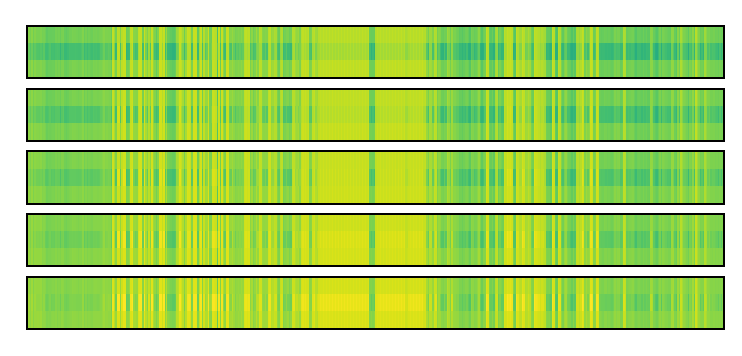

['elan', 'lan', 'n400', 'epnp', 'p600', 'pnp']


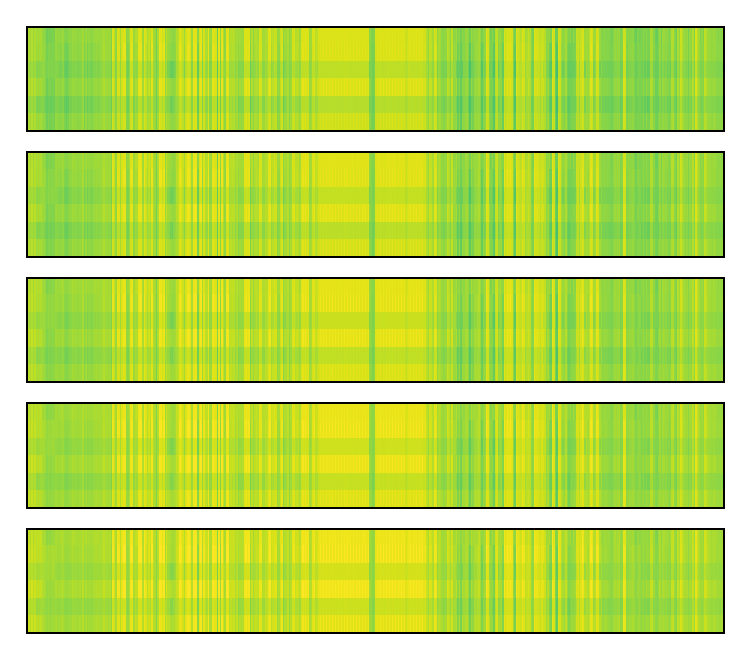

['first_fixation', 'first_pass', 'right_bounded', 'go_past', 'word_first_fixation_duration', 'word_fixation_count', 'word_gaze_duration', 'word_go_past_time', 'word_total_reading_time', 'dun_fst_pst', 'dun_go_pst', 'dun_rt_bnd']


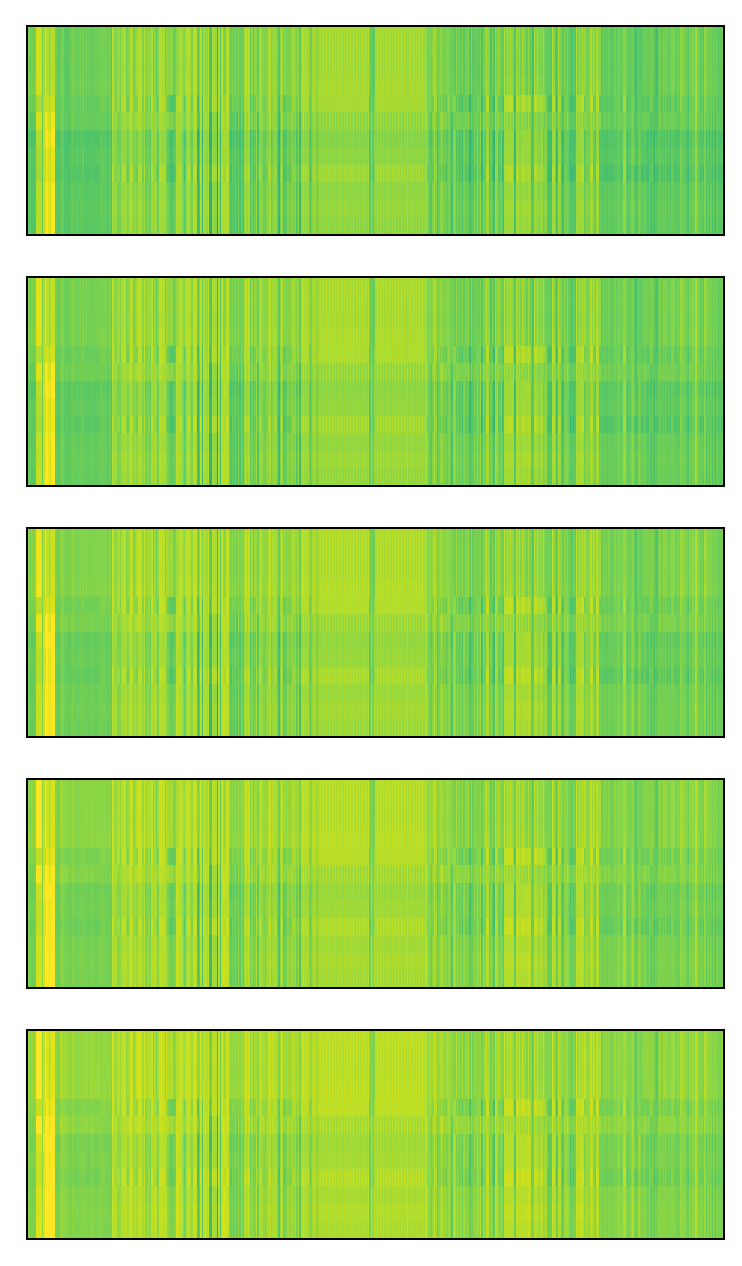

['reading_time']


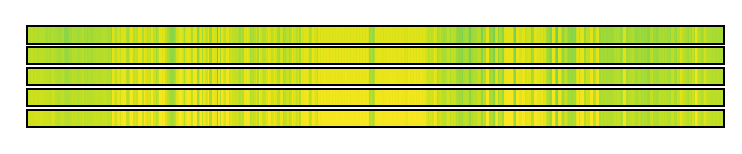

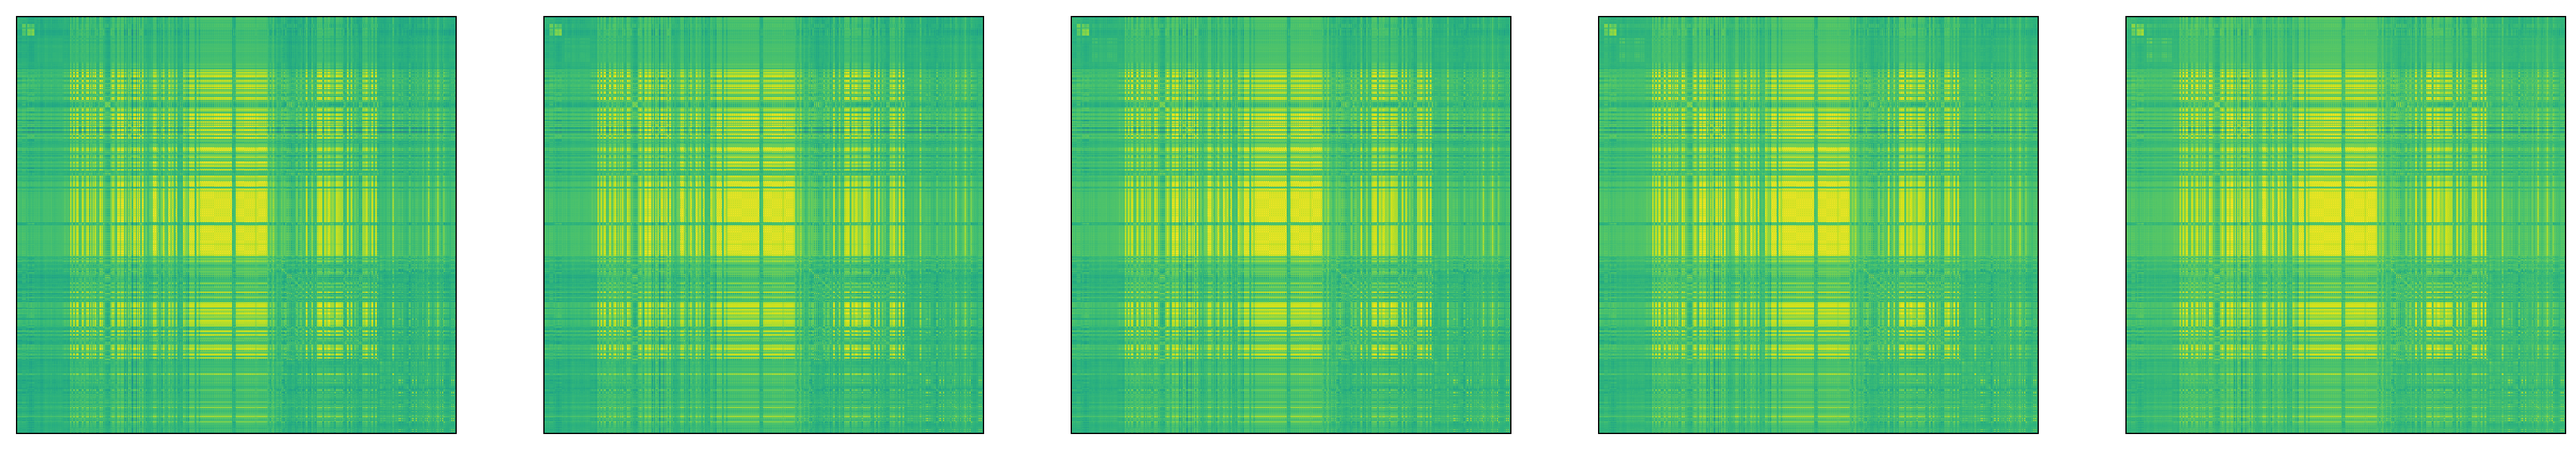

In [10]:
combined_mean_good = combined_mean[np.concatenate([np.array([True, True, True]), indicator_good_feature])]
combined_std_good = combined_std[np.concatenate([np.array([True, True, True]), indicator_good_feature])]

# non_fmri_names = list(n for n in ordered_names if not n.startswith('hp_fmri_'))
good_names = list(n for n, is_good in zip(non_fmri_names, indicator_good_feature) if is_good)

err_steps = list(range(-2, 3))

erp_set = {'n400', 'p600', 'pnp', 'epnp', 'elan', 'lan'}
eye_tracking_set = {'first_fixation', 'first_pass', 'right_bounded', 
     'go_past', 'word_first_fixation_duration', 
     'word_fixation_count', 'word_gaze_duration', 'word_go_past_time',
     'word_total_reading_time', 'dun_fst_pst', 'dun_go_pst', 'dun_rt_bnd'}
reading_time_set = {'reading_time'}

for set_names in [None, erp_set, eye_tracking_set, reading_time_set]:
    if set_names is None:  # fmri
        indices = np.array([0, 1, 2])
        names = list('fmri_{}'.format(idx) for idx in indices)
    else:
        indices = np.array(list(i + 3 for i, n in enumerate(good_names) if n in set_names))
        names = list(good_names[i - 3] for i in indices)
    print(names)
    vmax = np.quantile(combined_mean_good[indices] + 2 * combined_std_good[indices], 0.99)
    fig, axes = make_figure(
        [SubplotArtist(width=5, height=0.125 * len(indices)) for err_step in err_steps], dpi=180, 
        num_columns=1)
    for err_step, ax in zip(err_steps, axes):
        matshow(ax, np.maximum(combined_mean_good[indices] + err_step * combined_std_good[indices], 0), vmin=0, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.show()

vmax = np.quantile(combined_mean_good + 2 * combined_std_good, 0.99)

fig, axes = make_figure([SubplotArtist(width=5, height=5) for err_step in err_steps], dpi=180)
for err_step, ax in zip(err_steps, axes):
    matshow(ax, np.maximum(combined_mean_good + err_step * combined_std_good, 0), vmin=0, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
fig.show()


In [ ]:
num_neighbors = 20
indices_sort = np.argsort(-combined_mean_good, axis=1)
indices_sort = indices_sort[:, :(num_neighbors + 1)]
assert(len(good_names) == combined_mean_good.shape[1])

class LatexNearestTable:
    
    def __init__(self, num_neighbors):
        self.vmax = None
        self.neighbors = list()
        self.neighbor_values = list()
        self.names = list()
        self.num_neighbors = num_neighbors
        
    def clean(self, s):
        if s.startswith('hp_fmri_'):
            s = s[len('hp_fmri_'):]
        if s.startswith('top_const'):
            idx_top_const = 0
            for n in good_names:
                if n == s:
                    break
                elif n.startswith('top_const'):
                    idx_top_const += 1
            return 'tc.{}'.format(idx_top_const) 
        if s.startswith('ner_conll'):
            s = 'ne' + s[len('ner_conll'):]
        if s.startswith('srl_conll'):
            idx_srl = 0
            for n in good_names:
                if n == s:
                    break
                elif n.startswith('srl_conll'):
                    idx_srl += 1
            s = s.split('.')
            s = 'sr.{}.'.format(idx_srl) + s[-1]
        if s.startswith('sem_eval'):
            s = 'se' + s[len('sem_eval'):]
        if s.startswith('pos_conll.'):
            s = s[len('pos_conll.'):]
        if s.startswith('const_conll'):
            s = 'c' + s[len('const_conll'):]
        if s.startswith('coref_conll'):
            s = 'coref' + s[len('coref_conll'):]
        if s.startswith('dep_ewt'):
            idx_dep = 0
            for n in good_names:
                if n == s:
                    break
                elif n.startswith('dep_ewt'):
                    idx_dep += 1
            s = s.split('.')
            s = 'dp.{}.'.format(idx_dep) + s[-1]
        if s.startswith('spr1_'):
            s = 'pr1.' + s[len('spr1_'):]
        if s.startswith('spr2_'):
            s = 'pr2.' + s[len('spr2_'):]
        if s == 'word_go_past_time':
            return 'g.go'
        if s == 'word_gaze_duration':
            return 'g.fp'
        if s == 'word_first_fixation_duration':
            return 'g.fst'
        if s == 'word_total_reading_time':
            return 'g.trt'
        if s == 'word_fixation_count':
            return 'g.cnt'
        if s == 'go_past':
            return 'u.go'
        if s == 'first_pass':
            return 'u.fp'
        if s == 'first_fixation':
            return 'u.fst'
        if s == 'right_bounded':
            return 'u.rt'
        if s == 'reading_time':
            return 'u.spr'
        if s == 'dun_fst_pst':
            return 'd.fp'
        if s == 'dun_go_pst':
            return 'd.go'
        if s == 'dun_rt_bnd':
            return 'd.rt'
        if s.endswith('span0'):
            s = s[:-len('span0')] + '0'
        if s.endswith('span1'):
            s = s[:-len('span1')] + '1'
        s = s.replace('Cause-Effect(e1,e2)', 'c-e')
        s = s.replace('Cause-Effect(e2,e1)', 'e-c')
        s = s.replace('Entity-Destination(e1,e2)', 'e-d')
        s = s.replace('Entity-Destination(e2,e1)', 'd-e')
        s = s.replace('Content-Container(e1,e2)', 'c-in')
        s = s.replace('Content-Container(e2,e1)', 'in-c')
        s = s.replace('Member-Collection(e1,e2)', 'm-cl')
        s = s.replace('Member-Collection(e2,e1)', 'cl-m')
        s = s.replace('Instrument-Agency(e1,e2)', 'i-a')
        s = s.replace('Instrument-Agency(e2,e1)', 'a-i')
        s = s.replace('Product-Producer(e1,e2)', 'p-b')
        s = s.replace('Product-Producer(e2,e1)', 'b-p')
        s = s.replace('exists_as_physical', 'epys')
        s = s.replace('location_of_event', 'loc')
        s = s.replace('Component-Whole(e1,e2)', 'c-w')
        s = s.replace('Component-Whole(e2,e1)', 'w-c')
        s = s.replace('Message-Topic(e1,e2)', 'm-t')
        s = s.replace('Message-Topic(e2,e1)', 't-m')
        s = s.replace('Entity-Origin(e2,e1)', 'o-e')
        s = s.replace('Entity-Origin(e1,e2)', 'e-o')
        s = s.replace('change_of_state_continuous', 'stc')
        s = s.replace('predicate_changed_argument', 'pma')
        s = s.replace('makes_physical_contact', 'pysc')
        s = s.replace('manipulated_by', 'man')
        s = s.replace('change_of_possession', 'poss')
        s = s.replace('was_for_benefit', 'ben')
        s = s.replace('change_of_state', 'st')
        s = s.replace('existed_before', 'exb')
        s = s.replace('existed_during', 'exd')
        s = s.replace('existed_after', 'exa')
        s = s.replace('man_another', 'ma')  # what is man_another?
        s = s.replace('instigation', 'igt')
        s = s.replace('awareness', 'awr')
        s = s.replace('sentient', 'sn')
        s = s.replace('volition', 'v')
        s = s.replace('stationary', 'nmv')
        s = s.replace('WORK_OF_ART', 'art')
        s = s.replace('QUANTITY', 'qnt')
        s = s.replace('LANGUAGE', 'lng')
        s = s.replace('CARDINAL', 'crd')
        s = s.replace('ORDINAL', 'ord')
        s = s.replace('Other', 'oth')
        s = s.replace('PRODUCT', 'pdt')
        s = s.replace('PERSON', 'psn')
        s = s.replace('PERCENT', '%')
        s = s.replace('tree_depth', 'dpth')
        s = s.replace('sent_len', 'len')
        return s.replace('_', '\\_')
        
    def add(self, name, nearest, values):
        self.names.append(self.clean(name))
        self.neighbors.append([self.clean(n) for n in nearest])
        self.neighbor_values.append(values)
        if self.vmax is None:
            self.vmax = np.max(values)
        else:
            self.vmax = max(self.vmax, np.max(values))
            
    def longest(self):
        all_names = set()
        for row in self.neighbors:
            for n in row:
                all_names.add(n)
        for s in sorted(all_names, key=lambda x: -len(x)):
            print(s)
            
    def write(self, output_file):
        output_file.write(r'\begin{tabular}{' + 'c' * (self.num_neighbors + 1) + '}')
        output_file.write('\n')
        output_file.write(r'  \toprule')
        output_file.write('\n')
        output_file.write(r'  Name  & \multicolumn{' + '{}'.format(self.num_neighbors) + r'}{c}{Nearest Neighbors} \\')
        output_file.write('\n')
        output_file.write(r'  \midrule')
        output_file.write('\n')

        for name, nearest_names, values in zip(self.names, self.neighbors, self.neighbor_values):
            line = '  {}'.format(name)
            for value, nearest in zip(values, nearest_names):
                line += r' & \cellcolor{gray!' + '{}'.format(int(100 * value // vmax)) + '} ' + nearest
            for _ in range(len(nearest_names), num_neighbors):
                line += ' & '
            line += r' \\'
            output_file.write(line)
            output_file.write('\n')
        
        output_file.write(r'  \bottomrule')
        output_file.write('\n')
        output_file.write(r'\end{tabular}')
        output_file.write('\n')
    
table = LatexNearestTable(num_neighbors)
    
# for k in most_reliable_voxel_means:
#     indices_sort_most_reliable = np.argsort(-most_reliable_voxel_means[k], axis=1)
#     indices_sort_most_reliable = indices_sort_most_reliable[:, :(num_neighbors + 1)]
#     for i, nearest in enumerate(indices_sort_most_reliable):
#         nearest = nearest[most_reliable_voxel_means[k][i, nearest] - 2 * most_reliable_voxel_std_err[k][i, nearest] > 0]
#         nearest = nearest[:num_neighbors]
#         name = '{}_{}'.format(k, i)
#         nearest_names = list(good_names[n] for n in nearest)
#         table.add(name, nearest_names, most_reliable_voxel_means[k][i, nearest])
#         fig, ax = make_figure(SubplotArtist(width=5, height=1), dpi=180)
#         bar(ax, 
#             most_reliable_voxel_means[k][i, nearest], 
#             most_reliable_voxel_std_err[k][i, nearest], 
#             name, 
#             nearest_names)
#         fig.show()

for i, nearest in enumerate(indices_sort):
    if i < 3:
        # looser for fMRI
        nearest = nearest[combined_mean_good[i, nearest] - combined_std_good[i, nearest] > 0][:num_neighbors]
        name = 'fmri_{}'.format(i)
    else:
        nearest = nearest[combined_mean_good[i, nearest] - 2 * combined_std_good[i, nearest] > 0]
        nearest = nearest[nearest != i - 3][:num_neighbors]
        name = good_names[i - 3]
    nearest_names = list(good_names[n] for n in nearest)
    table.add(name, nearest_names, combined_mean_good[i, nearest])
#     fig, ax = make_figure(SubplotArtist(width=5, height=1), dpi=180)
#     bar(ax,
#         combined_mean_good[i, nearest], 
#         combined_std_good[i, nearest],
#         name,
#         nearest_names)
#     fig.show()

# table.longest()

with open('latex_nearest.txt', 'wt') as latex_file:
    table.write(latex_file)


In [178]:
from subplot_artist import SubplotArtistGrid
import matplotlib

nlp_x = combined_mean[3:][indicator_good_feature]
nlp_x_std = combined_std[3:][indicator_good_feature]

nlp_abs = combined_mean_abs[3:][indicator_good_feature]
nlp_abs_std = combined_std_abs[3:][indicator_good_feature]


def indicator_at_least():
    indicator_result = np.full(np.sum(indicator_good_feature), False)
    names = list()
    for i, n in enumerate(n for b, n in zip(indicator_good_feature, non_fmri_names) if b):
        current_at_least = None
        if n.startswith('spr1_') or n.startswith('spr2_'):
            prefix = n[:len('spr1_')]
            k = n[len('spr1_'):].split('.')[0]
        else:
            prefix = None
            k = None
            parts = n.split('.')
            if len(parts) > 1:
                prefix = parts[0]
                k = parts[1]
        if prefix in at_least_1_percent:
            current_at_least = at_least_1_percent[prefix]
        indicator_result[i] = current_at_least is None or k in current_at_least
        if indicator_result[i]:
            names.append(n)
    return indicator_result, names


indicator_keep, good_names = indicator_at_least()
nlp_x = nlp_x[indicator_keep][:, indicator_keep]
nlp_x_std = nlp_x_std[indicator_keep][:, indicator_keep]
nlp_abs = nlp_abs[indicator_keep][:, indicator_keep]
nlp_abs_std = nlp_abs_std[indicator_keep][:, indicator_keep]

fmri_dict = fmri_summary('cos')
fmri_names = dict()
fmri = list()
for subj in fmri_dict:
    for roi in fmri_dict[subj]:
        fmri.append(fmri_dict[subj][roi])
        fmri_names[len(fmri_names)] = 'fmri_{}_{}'.format(subj, roi)
fmri = np.concatenate(fmri)
fmri_std = np.full_like(fmri, np.nan)


combined_mean_good = np.concatenate(
    [fmri[:, indicator_keep], nlp_x])
combined_std_good = np.concatenate(
    [fmri_std[:, indicator_keep], nlp_x_std])

# z = np.copy(combined_mean_good[len(fmri):])
# np.fill_diagonal(z, 0)
# z = np.reshape(z, -1)
# indices_all_pair_sort = np.argsort(-np.abs(z))
# count = 0
# for index_pair in indices_all_pair_sort:
#     row, col = np.unravel_index(index_pair, combined_mean_good[len(fmri):].shape)
#     if col > row:
#         print(good_names[row], good_names[col], combined_mean_good[row + len(fmri), col])
#         count += 1
#     if count == 200:
#         break

num_neighbors = 20
indices_sort = np.argsort(-np.abs(combined_mean_good), axis=1)
indices_sort = indices_sort[:, :(num_neighbors + 1)]
assert(len(good_names) == combined_mean_good.shape[1])
    
# for k in most_reliable_voxel_means:
#     indices_sort_most_reliable = np.argsort(-most_reliable_voxel_means[k], axis=1)
#     indices_sort_most_reliable = indices_sort_most_reliable[:, :(num_neighbors + 1)]
#     for i, nearest in enumerate(indices_sort_most_reliable):
#         nearest = nearest[most_reliable_voxel_means[k][i, nearest] - 2 * most_reliable_voxel_std_err[k][i, nearest] > 0]
#         nearest = nearest[:num_neighbors]
#         name = '{}_{}'.format(k, i)
#         nearest_names = list(good_names[n] for n in nearest)
#         table.add(name, nearest_names, most_reliable_voxel_means[k][i, nearest])
#         fig, ax = make_figure(SubplotArtist(width=5, height=1), dpi=180)
#         bar(ax, 
#             most_reliable_voxel_means[k][i, nearest], 
#             most_reliable_voxel_std_err[k][i, nearest], 
#             name, 
#             nearest_names)
#         fig.show()

erp_set = {'n400', 'p600', 'pnp', 'epnp', 'elan', 'lan'}
eye_tracking_set = {'first_fixation', 'first_pass', 'right_bounded', 
     'go_past', 'word_first_fixation_duration', 
     'word_fixation_count', 'word_gaze_duration', 'word_go_past_time',
     'word_total_reading_time', 'dun_fst_pst', 'dun_go_pst', 'dun_rt_bnd'}
reading_time_set = {'reading_time'}

# nlp tasks that don't naturally group
binary_seq_set = {'dpr', 'bshift', 'coord_inv', 'obj_num', 'somo', 'subj_num', 'tense', 'sentiment'}
sent_len_set = {'sent_len', 'tree_depth'}
sr_core_set = {'srl_conll.ARG0', 'srl_conll.ARG1', 'srl_conll.ARG2'}
dep_core_set = {
    'dep_ewt.nsubj', 
    'dep_ewt.cop', 
    'dep_ewt.amod', 
    'dep_ewt.nmod:poss', 
    'dep_ewt.nmod', 
    'dep_ewt.obj', 
    'dep_ewt.obl',
    'dep_ewt.punct'}
proto_core_set = {
    'spr1_awareness', 
    'spr1_change_of_state', 
    'spr1_existed_after',
    'spr1_exists_as_physical',
    'spr1_location_of_event',
    'spr1_makes_physical_contact',
    'spr1_manipulated_by',
    'spr1_predicate_changed_argument'}

groups = OrderedDict()

for i, nearest in enumerate(indices_sort):
    if i < len(fmri):
        # looser for fMRI
        name = fmri_names[i]
        nearest = nearest[:num_neighbors]
    else:
        name = good_names[i - len(fmri)]
        nearest = nearest[np.abs(combined_mean_good[i, nearest]) - 2 * combined_std_good[i, nearest] > 0]
        if name in erp_set:
            print(name, len(nearest))
        nearest = nearest[nearest != i - len(fmri)][:num_neighbors]
        
    nearest_names = list(good_names[n] for n in nearest)
    if name.startswith('fmri_'):
        group = name[:len('fmri_') + 1]
    elif name in erp_set:
        group = 'erp'
    elif name in eye_tracking_set:
        group = 'eye'
    elif name in reading_time_set:
        group = 'read'
#     elif name.startswith('spr1_'):  # or name.startswith('spr2_'):
#         group = 'proto'
#     elif name.startswith('ner_conll'):
#         group = 'ner'
#     elif name.startswith('pos_conll') or name.startswith('const_conll'):
#         group = 'pos'
#     elif name.startswith('top_const'):
#         group = 'top_const'
#     elif name.startswith('sem_eval') and '(e1,e2)' in name:
#         group = 'sem_eval'
#     elif name.startswith('coref'):
#         group = 'coref'
    else:
        group = None
#         for prefix in binary_seq_set:
#             if name.startswith(prefix):
#                 group = 'binary_seq'
#                 break
#         for prefix in sr_core_set:
#             if name.startswith(prefix):
#                 group = 'sr_core'
#                 break
#         for prefix in dep_core_set:
#             if name.startswith(prefix):
#                 group = 'dep'
#                 break
#         for prefix in proto_core_set:
#             if name.startswith(prefix):
#                 group = 'proto'
#                 break
        if group is None:
            for prefix in sent_len_set:
                if name.startswith(prefix):
                    group = 'sent_len'
        if group is None:
            group = 'other'
    if group not in groups:
        groups[group] = list()
    groups[group].append((i, name, nearest_names, nearest))

    
# combine eye and read into a single group
groups['eye'].extend(groups['read'])
del groups['read']

# resort sent_len group numerically
groups['sent_len'] = list(sorted(groups['sent_len'], key=lambda x: (x[1].split('.')[0], int(x[1].split('.')[1]))))

# groups['other'].extend(groups['binary_seq'])
groups['other'].extend(groups['sent_len'])


def get_colors(map_name='tab10'):
    colormap_counts = {
        'Pastel1': 9,
        'Pastel2': 8,
        'Paired': 12,
        'Accent': 8,
        'Dark': 8,
        'Set1': 9,
        'Set2': 8,
        'Set3': 12,
        'tab10': 10,
        'tab20': 20,
        'tab20b': 20,
        'tab20c': 20
    }
    
    if map_name == 'tab20_light':
        return [c for i, c in enumerate(get_colors('tab20')) if i % 2 == 1]
            
    cmap = matplotlib.cm.get_cmap(map_name)
    return list(cmap(i / colormap_counts[map_name]) for i in range(colormap_counts[map_name]))
        
colors = get_colors('tab20_light')
patterns = (None, '//', '\\', '-', '+', 'x', '*', 'o', 'O', '.')

def fix_name(s):
    if s.startswith('spr1_'):
        s = 'pr1.' + s[len('spr1_'):]
    if s.startswith('spr2_'):
        s = 'pr2.' + s[len('spr2_'):]
    if s.startswith('sem_eval.'):
        return 'se.' + s[len('sem_eval.'):]
    if s == 'word_go_past_time':
        return 'g.go'
    if s == 'word_gaze_duration':
        return 'g.fp'
    if s == 'word_first_fixation_duration':
        return 'g.fst'
    if s == 'word_total_reading_time':
        return 'g.trt'
    if s == 'word_fixation_count':
        return 'g.cnt'
    if s == 'go_past':
        return 'u.go'
    if s == 'first_pass':
        return 'u.fp'
    if s == 'first_fixation':
        return 'u.fst'
    if s == 'right_bounded':
        return 'u.rt'
    if s == 'reading_time':
        return 'u.spr'
    if s == 'dun_fst_pst':
        return 'd.fp'
    if s == 'dun_go_pst':
        return 'd.go'
    if s == 'dun_rt_bnd':
        return 'd.rt'
    if s.startswith('dep_ewt.'):
        return 'dp.' + s[len('dep_ewt.'):]
    if s.startswith('const_conll.'):
        return 'c.' + s[len('const_conll.'):]
    if s.startswith('top_const.'):
        return 'tc.' + s[len('top_const.'):]
    if s.startswith('pos_conll.'):
        return s[len('pos_conll.'):]
    if s.startswith('srl_conll.'):
        return 'sr.' + s[len('srl_conll.'):]
    return s.replace('_conll.', '.').replace('manipulated_by_another', 'man').replace('predicate_changed_argument', 'pred_chng_arg').replace('change_of_state_continuous', 'chng_st_cont')

num_axes_per_figure = 20

for group_name in groups:
    
    group = groups[group_name]
    
    if group_name == 'other':
        num_parts = int(np.ceil(len(group) / num_axes_per_figure))
        num_columns = 7
    else:
        num_parts = 1
        if group_name == 'eye' or group_name == 'sent_len':
            num_columns = 5
        elif group_name.startswith('fmri'):
            num_columns = 5
        else:
            num_columns = 4
        
    for idx_part in range(num_parts):
        if num_parts > 1:
            part_group = group[idx_part*num_axes_per_figure:(idx_part+1)*num_axes_per_figure]
        else:
            part_group = group
        fig, axes = make_figure(
            [SubplotArtist(width=1.8, height=5) for _ in range(len(part_group) + 1)], num_columns=num_columns, dpi=180)
        for ax, (i, name, nearest_names, nearest) in zip(axes[:-1], part_group):
            y = np.arange(len(nearest)) * 0.4
            y = y[-1] - y
            bars = ax.barh(
                y, 
                combined_mean_good[i, nearest],
                height=0.3)
            ax.errorbar(
                y=y + 0.1, 
                x=combined_mean_good[i, nearest], 
                xerr=combined_std_good[i, nearest],
                fmt='none',
                ecolor='black',
                elinewidth=1)
            ax.axvline(0, linestyle='--', color='black', linewidth=0.5)
            for bar, k in zip(bars, nearest_names):
                if k in erp_set:
                    color = colors[0]
                elif k in eye_tracking_set or k in reading_time_set:
                    color = colors[1]
                elif k.startswith('srl_conll') or k.startswith('spr1_') or k.startswith('spr2_'):
                    color = colors[2]
                elif k.startswith('ner_conll'):
                    color = colors[3]
                elif k.startswith('sem_eval'):
                    color = colors[4]
                elif k.startswith('top_const') \
                        or k.startswith('const_conll') \
                        or k.startswith('pos_conll') \
                        or k == 'obj_num' \
                        or k == 'subj_num' \
                        or k == 'tense':
                    color = colors[5]
                elif k.startswith('dep_ewt'):
                    color = colors[6]
                elif k.startswith('tree_depth') or k.startswith('sent_len.'):
                    color = colors[7]
                else:
                    color = colors[8]
                bar.set_color(color)
            name = fix_name(name)
            if name.startswith('se.') or name.startswith('pr1.') or name.startswith('pr2.'):
                ax.set_title(name, fontsize=6)
            else:
                ax.set_title(name, fontsize=10)
            ax.set_yticklabels([fix_name(s) for s in nearest_names], horizontalalignment='left')
            ax.set_yticks(y)
            ax.tick_params(axis='y', direction='in', length=0, pad=-5, labelsize=6)
        ax = axes[-1]
        legend = [
            'ERP', 
            'Eye-tracking / SPR', 
            'Semantic role', 
            'Named entity', 
            'SemEval', 
            'PoS/Constit.', 
            'Dependency role',
            'Tree-depth/Sent. length',
            'Other']
        # fig, ax = make_figure(SubplotArtist(width=1.8, height=5), dpi=180)
        bars = ax.barh(
            len(legend) - 1 - np.arange(len(legend)),
            [0.4] * len(legend))
        for bar, c in zip(bars, colors):
            bar.set_color(c)
        ax.tick_params(axis='y', direction='in', length=0, pad=-5, labelsize=8)
        ax.set_yticklabels([lbl for lbl in reversed(legend)], horizontalalignment='left')
        ax.set_yticks(np.arange(len(legend)))
        ax.set_xticks([])
        ax.set_title('Legend')
        output_name = '{}_{}'.format(group_name, idx_part) if num_parts > 1 else group_name
        fig.show('{}_similarities.pdf'.format(output_name), is_tight_layout=True)
        # fig.show(is_tight_layout=True)


elan 21
lan 21
n400 21
epnp 21
p600 21
pnp 21


In [26]:
label_dict = OrderedDict()
for k_labels, k in zip(labels, bootstrap_indicator_fmri_stat_sig):
    full = np.full(len(bootstrap_indicator_fmri_stat_sig[k]), np.nan)
    full[bootstrap_indicator_fmri_stat_sig[k]] = k_labels
    label_dict[k] = full

In [28]:
volume_dict = OrderedDict()
for key in label_dict:
    volume_dict[key[-1]] = make_volume(label_dict[key], key[-1], cmap='BROYG', vmin=0, vmax=4)
    
cortex.webshow(volume_dict, open_browser=False)

Started server on port 2146


<WebApp(Thread-10, started 140707719583488)>

Stopping server


In [ ]:
# print_variation_results(paths, 'fmri_cram_cpg_prop_wide', index_run=0)
print_variation_results(paths, 'fmri_raw_dds_direct')
# print_variation_results(paths, 'fmri_cram_cpg_cca_ica', index_run=lambda num_runs: range(0, num_runs, 4))
# print_variation_results(paths, 'fmri_cram_cpg_cca_ica', index_run=lambda num_runs: range(1, num_runs, 4))
# print_variation_results(paths, 'fmri_cram_cpg_cca_ica', index_run=lambda num_runs: range(2, num_runs, 4))
# print_variation_results(paths, 'fmri_cram_cpg_cca_ica', index_run=lambda num_runs: range(3, num_runs, 4))

/usr0/home/drschwar/src/bert_brain/bert_brain/loss_curves.py:37: RuntimeWarning: Mean of empty slice
  epoch_values.append(np.nanmean(curve.values[curve.epochs == epoch]))


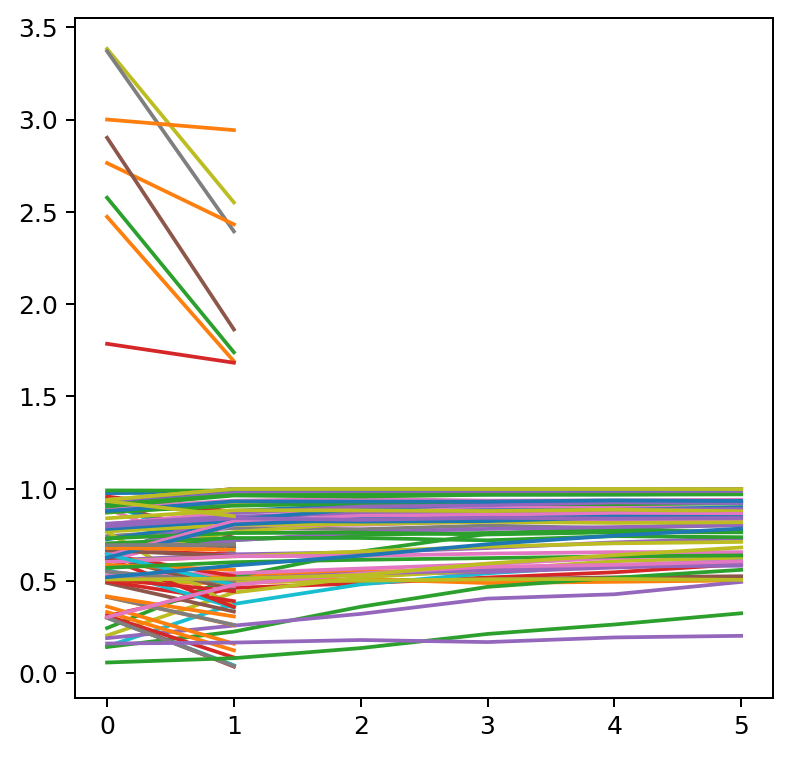

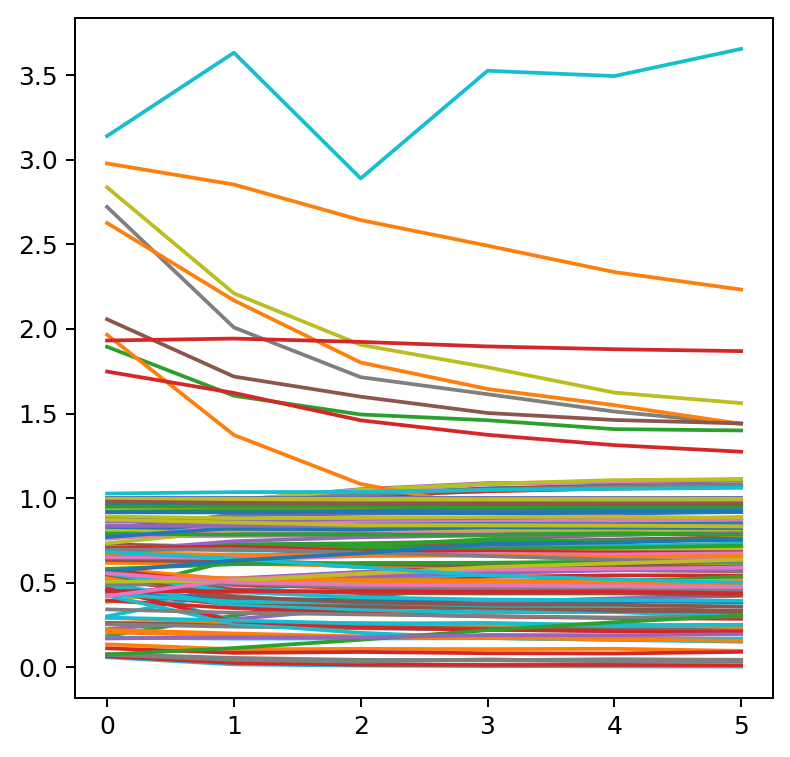

bshift 0 train 0 0.6943666599155403
bshift.acc 1 train 5 0.6087761876588301
const_conll 2 train 1 1.7389791187486625
const_conll.acc 3 train 5 0.5913356826357357
coord_inv 4 train 0 0.69599678995625
coord_inv.acc 5 train 5 0.5260213279170138
coref_conll 6 train 1 0.4734135168962272
coref_conll.acc 7 train 5 0.8032874489597465
dep_ewt 8 train 1 2.5509662058569966
dep_ewt.acc 9 train 5 0.609725897339391
dpr 10 train 0 0.7027402044478843
dpr.acc 11 train 2 0.5105184968180271
dun_fst_pst 12 train 1 0.8557162450926539
dun_go_pst 13 train 1 0.8751660895785686
dun_rt_bnd 14 train 0 0.9422403864045227
elan 15 train 1 0.7348469887478424
epnp 16 train 0 0.9145316316237588
first_fixation 17 train 0 0.7756417332804293
first_pass 18 train 1 0.3598683063552435
go_past 19 train 0 0.792016145080218
hp_fmri_F 20 train 0 0.9762177010279623
hp_fmri_G 21 train 0 0.9726013501577355
hp_fmri_H 22 train 1 0.9896681623514041
hp_fmri_I 23 train 1 0.9812332169852964
hp_fmri_J 24 train 0 0.9831716384058587
hp_fmr

In [2]:
variation = 'fmri_raw_dds_direct'
curves = loss_curves_for_variation(paths, variation)

average_unique_epochs_within_loss_curves(curves)
curves = average_over_runs(curves)    
train_curves = [c for c in curves if c.train_eval_kind == 'train']
validation_curves = [c for c in curves if c.train_eval_kind == 'validation']


def print_min_values(curves):
    for i, curve in enumerate(sorted(curves, key=lambda c: c.key)):
        try:
            if curve.key.endswith('.acc'):
                index_best = np.nanargmax(curve.values)
            else:
                index_best = np.nanargmin(curve.values)
            print(curve.key, i, curve.train_eval_kind, index_best, curve.values[index_best])
        except ValueError:
            pass

        
def render_curves(ax, curves):
    for curve in sorted(curves, key=lambda c: c.key):
        ax.plot(curve.epochs, curve.values, label=curve.key)


fig, ax = make_figure(SubplotArtist(width=5, height=5), dpi=180)
render_curves(ax, train_curves)
fig.show()

fig, ax = make_figure(SubplotArtist(width=5, height=5), dpi=180)
render_curves(ax, validation_curves)
fig.show()

print_min_values(train_curves)
print('')
print_min_values(validation_curves)